# Predicting Wine Quality using Deep Learning

The dataset considered is "Wine Quality".   

Problem:
Load the data and train a prediction model for the target variable quality. Compare several candidate neural network architectures, and make a decision about which is best for the task at hand. Be explicit about the indicator(s) you base your decision on.

Finally, as a bonus, evaluating whether it is better to:

(a). train a single model for both white and red wine ;  
(b). train two different models, one for white wine and another one for red wine ;  
(c).  train a model on white wine (respectively red wine) and fine-tune it on red wine (resp. white wine).

## Importing Data and Installing Libraries

In [ ]:
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [ ]:
wine_quality = fetch_ucirepo(name="Wine Quality")
dataset = wine_quality.data.original

In [ ]:
# Setting Keras seed so results are reproducible

keras.utils.set_random_seed(49)

## Pre-processing dataset

In [ ]:
# printing the first 5 rows
display(dataset.head())

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


We see from the dataset info that there are no null values.

In [ ]:
print("Number of Duplicates in dataset:",dataset.duplicated().sum())

Number of Duplicates in dataset: 1177


In [ ]:
print("Duplicated targets:\n", dataset[dataset.duplicated()]["quality"].value_counts())

Duplicated targets:
 6    513
5    386
7    223
8     45
4     10
Name: quality, dtype: int64


We decided to remove duplicates from our dataset because the presence of repeated observations can bias the results of our analysis and our models. We see a  significant number of duplicates are present across multiple categories. Removing the duplicates ensures the integrity of the data and leads to more accurate and general insights.

In [ ]:
dataset = dataset.drop_duplicates()
dataset

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [ ]:
## Finding the numerical and categorical variables

minModalities = 7 ## To match dataset desciprtion on UCI website, numerical variables with less than 7 modalities are considered as nominal

def getCategFeat(df, n, target):
    """
    get dataframe's categorical features
    Inputs :
        df     -- dataframe
        n      -- min modalities for numerical features
        target -- target column name
    """
    return [c for c in df.columns if (df[c].dtype == 'O' or df[c].nunique()<n) and c!=target]


categorical_features = getCategFeat(dataset,minModalities,'quality')

print("Categorical Features : ",categorical_features)
numerical_features = [c for c in dataset.columns if c not in categorical_features and c!="quality"]
print("Numerical Features : ", numerical_features)

output_variable = ['quality']


Categorical Features :  ['color']
Numerical Features :  ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Exploratory  Data Analysis

In this stage we explore the dataset further. We look at the target variable, as well as relationships and distributions of the features with respect to the target variable.

Text(0.5, 1.0, 'Distribution of quality for white wine')

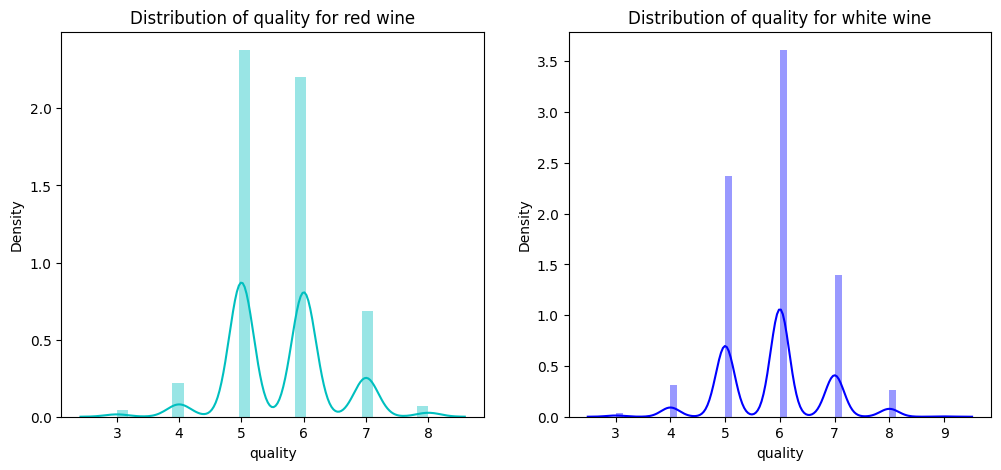

In [ ]:
## Distribution of Quality for Color

f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(dataset[(dataset.color == 'red')]["quality"],color='c',ax=ax)
ax.set_title('Distribution of quality for red wine')

ax=f.add_subplot(122)
sns.distplot(dataset[(dataset.color == 'white')]['quality'],color='b',ax=ax)
ax.set_title('Distribution of quality for white wine')

### **Key Observations** - ***IMBALANCED DATA***


*   **Central Tendency**: Both graphs show that the majority of wines are rated around 5 or 6, with this being particularly pronounced for white wines.
*   **Spread and Skewness**: Red wine scores have a spread out distribution with several peaks, which suggests that the quality ratings for red wines are more varied. White wine scores are more skewed towards the score of 6, showing a higher concentration of white wines rated at this quality.

*   **Extremes**: There are fewer instances of very high and very low quality ratings for both red and white wines.
*   **Comparison between Red and White Wine**: White wines have a higher peak at the quality score of 6 whereas red wines have a more even distribution of quality ratings around 5 and 6, indicating a less steep concentration compared to white wines.







**<big><i>Potential Solutions:</i></big>**

<ul>
 <li> <u>Stratified Cross-validation</u> :
We will try to keep the same number of each target class in each fold. <i>This should help the model understand the imbalance</i></li>

<li> <u>Class Weighting</u> :
Certain models allow for class weightings to be added as parameters.</li>

<li> <u>Additional Features</u> :
Create features that help our model identify distinguishing characteristics of certain classes.</li>
</ul>

<big>**Over/Under Sampling**</big>

<ul>
<li> <b>SMOTE (Synthetic Minority Over-sampling Technique)</b>:
SMOTE creates synthetic data by oversampling minority classes. Testing is required, as synthetic data could likely negatively impact the score.</li>

<li> <b>Undersampling</b>: We can remove majority samples to even out the classes. Due to the small number of samples, removing samples would be a poor choice, as this reduces our dataset significantly.</li>
</ul>


In the graphs below, we show the distribution of wine quality scores against each numerical feature in the dataset. We want to see if different quality scores can be distinguished based on these features.

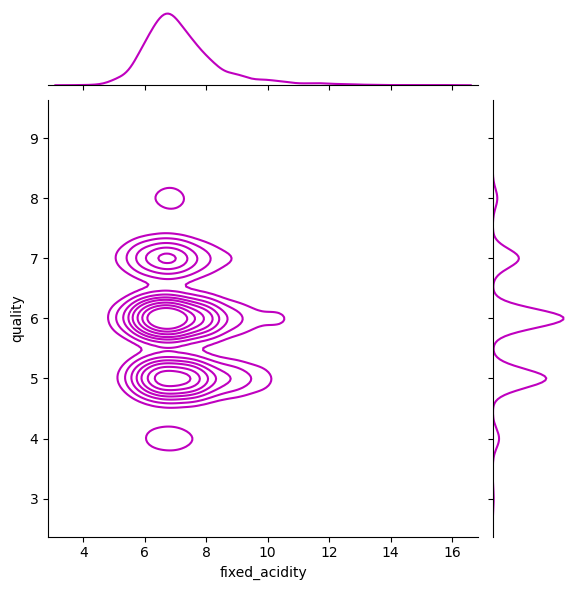

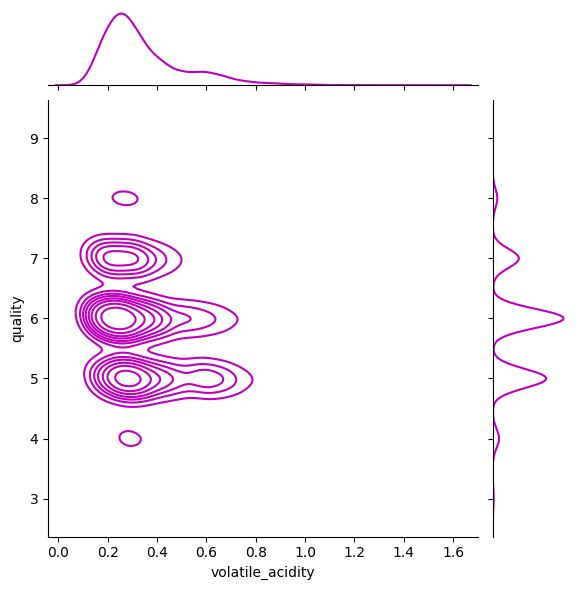

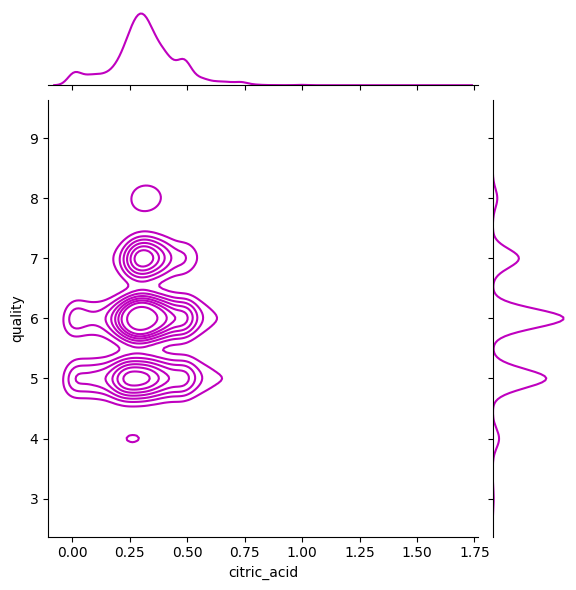

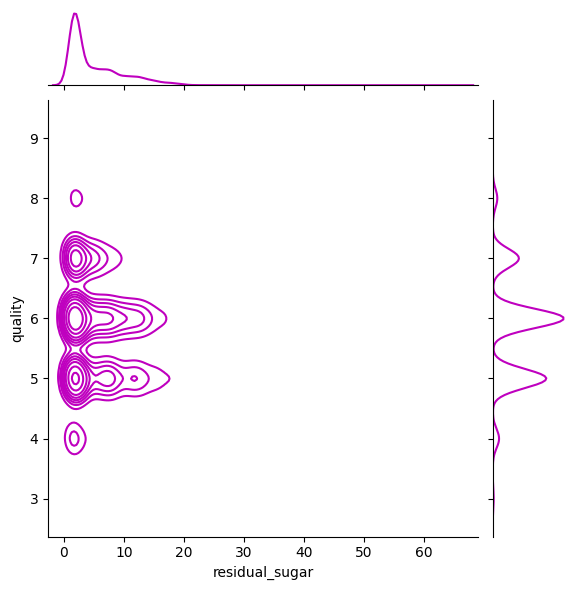

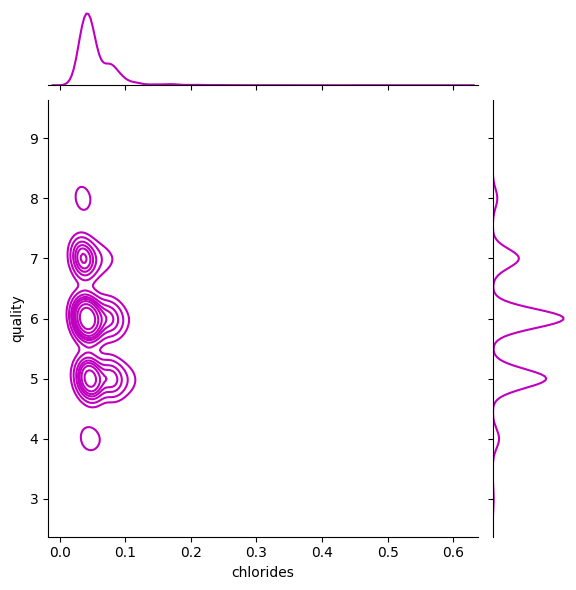

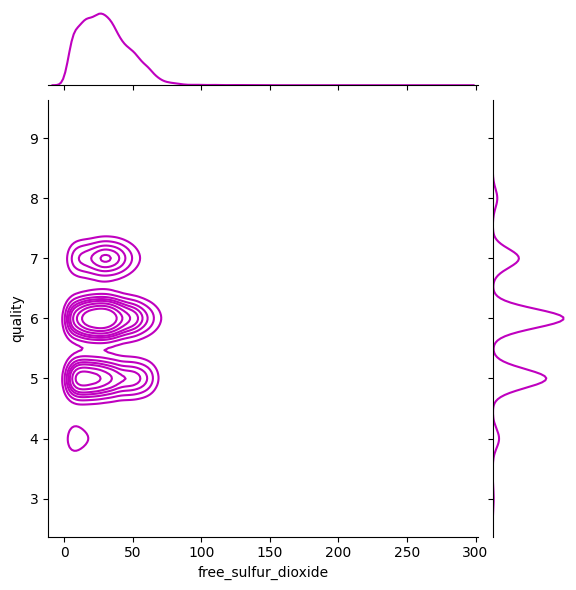

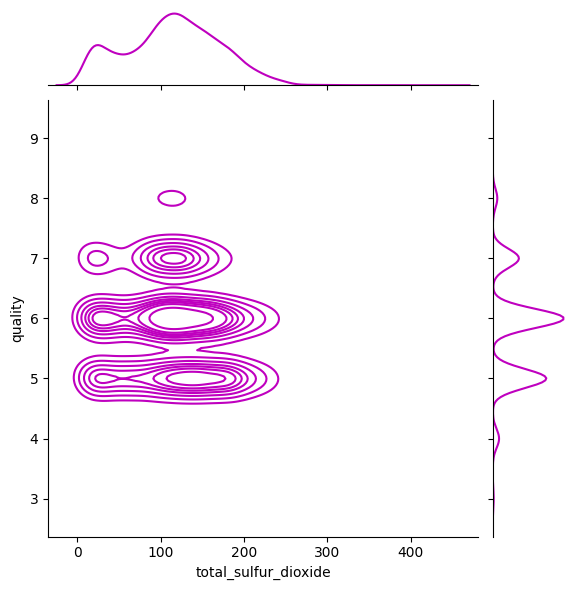

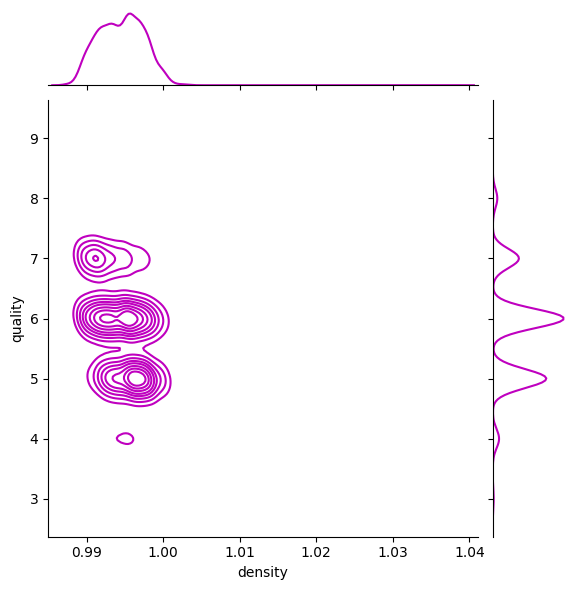

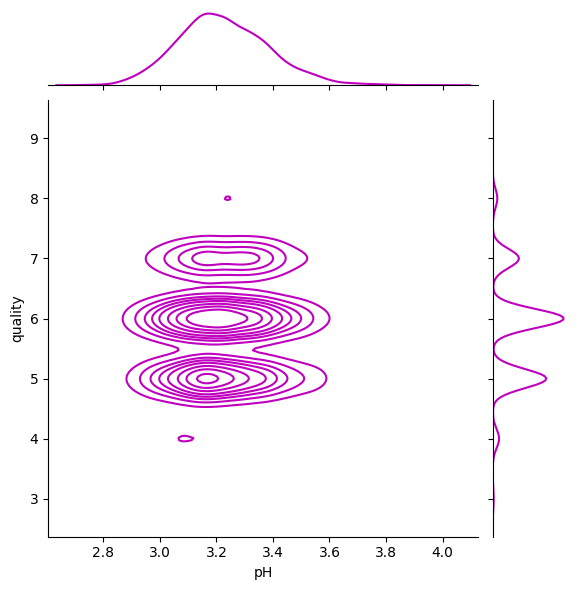

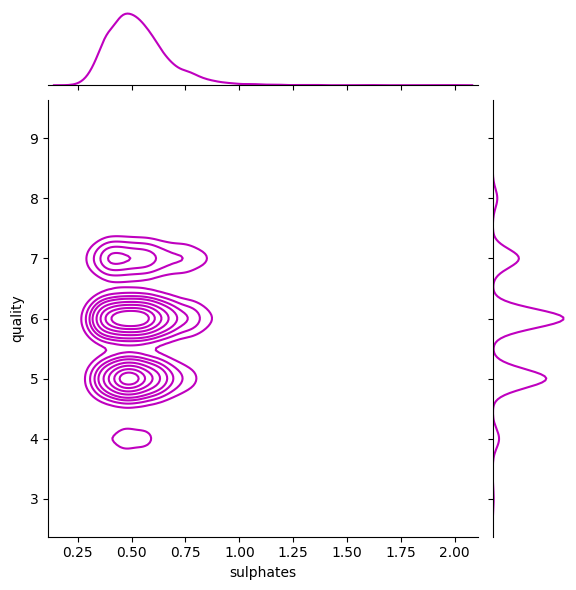

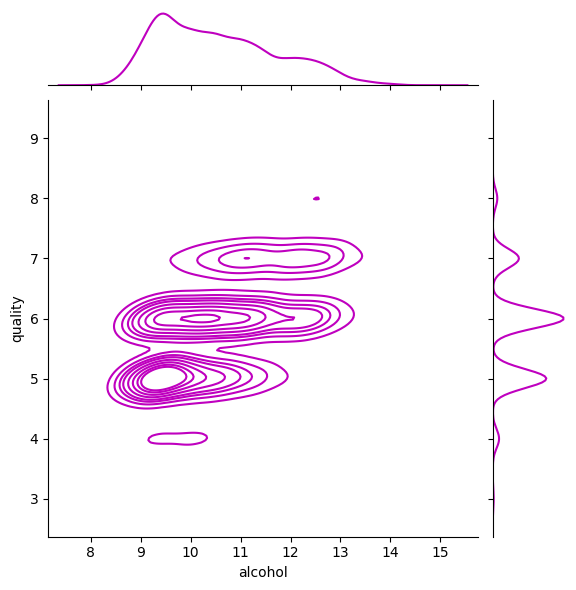

In [ ]:
for num_var in numerical_features:
    g = sns.jointplot(x=num_var, y="quality", data = dataset, kind="kde", color="m")
    g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels(num_var, "quality")
    ax.set_title('Distribution of wine quality scores against wine features')

We show the features grouped by quality below.

<Axes: xlabel='quality'>

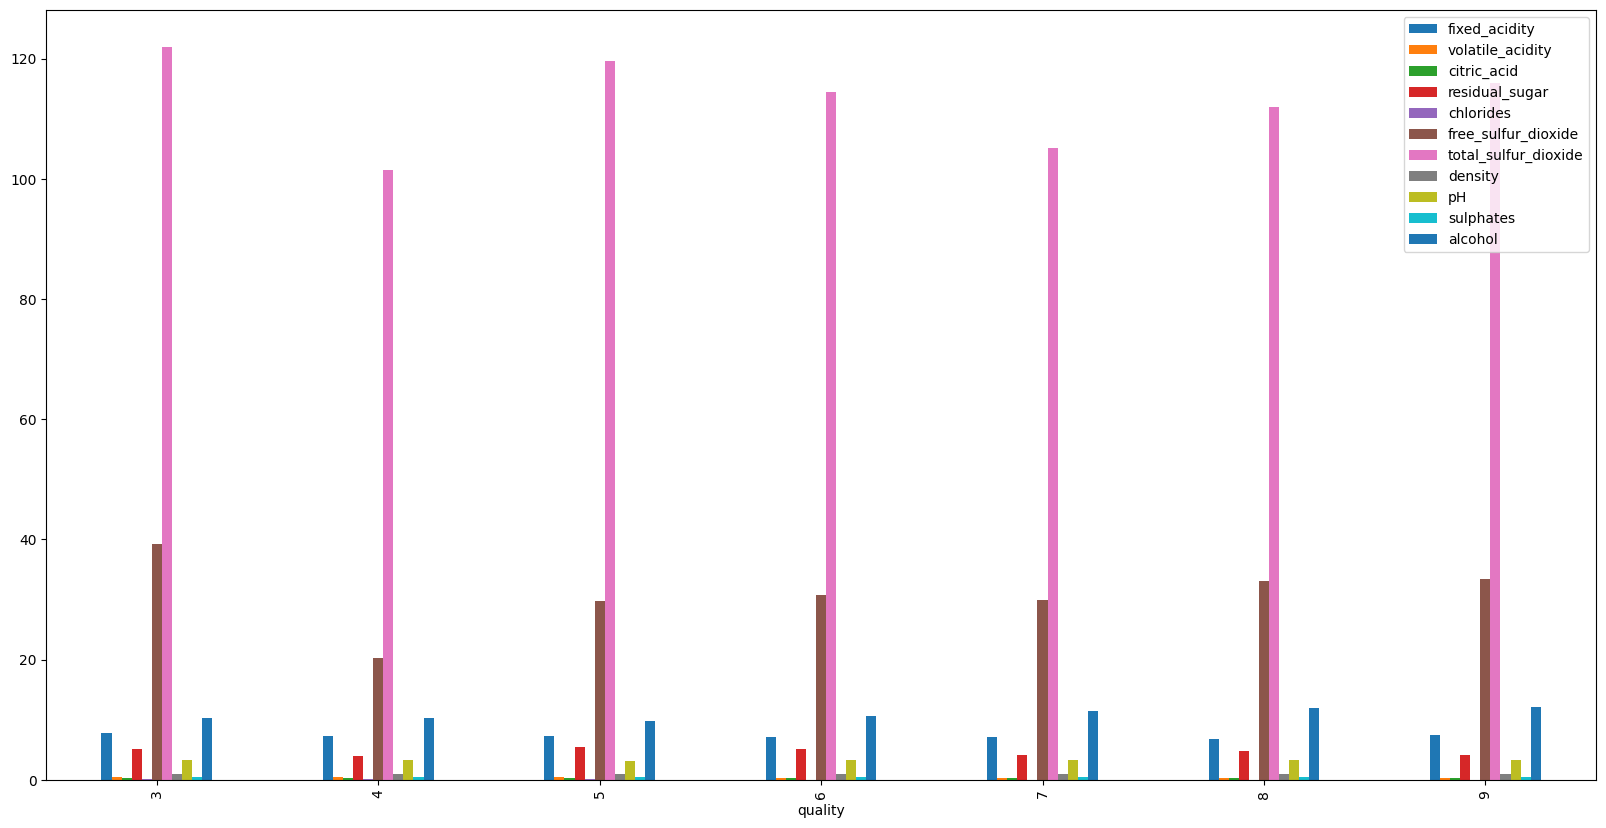

In [ ]:
group_quality= dataset.groupby("quality").mean(numeric_only=True)
group_quality.plot(kind="bar",figsize=(20,10))

The graphs above show that it's difficult to distinguish the scores with the features that we have. Let's try to identify relationships between our features.

In [ ]:
dataset_correlations = dataset.corr(method='spearman', numeric_only = True)

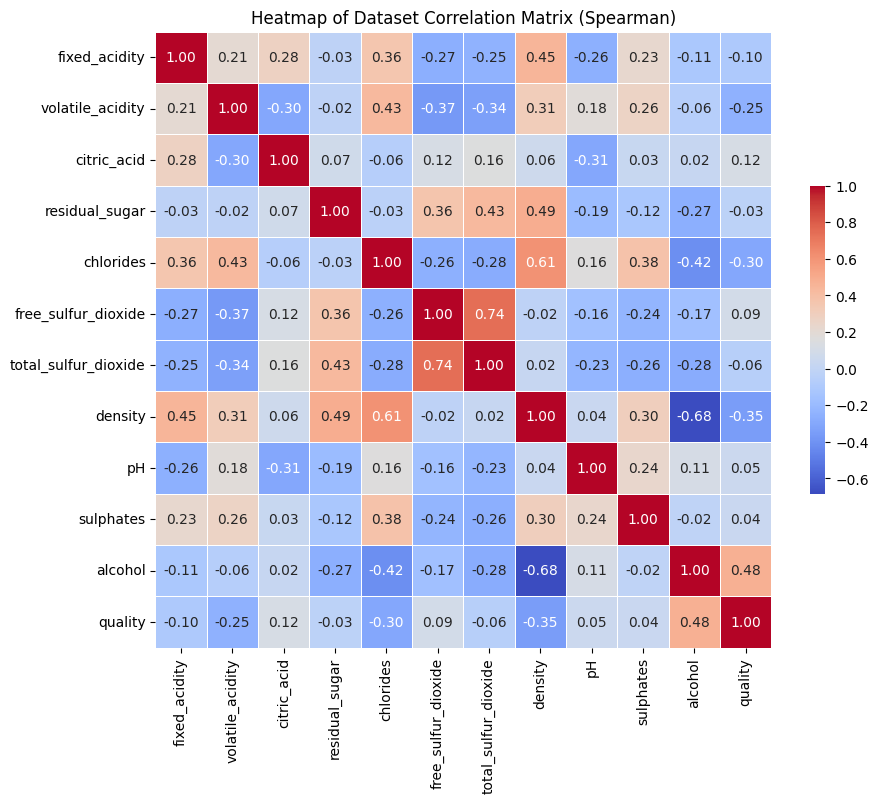

In [ ]:
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dataset_correlations, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Heatmap of Dataset Correlation Matrix (Spearman)')
plt.show()

**Insights on Correlation**

Features that contain similar (correlated / mutual) information negatively impact certain models as this can cause overfitting.
High correlation between a number of features, for example:
- 'total sulphur dioxide' and 'free sulpher dioxide' have a large positive correlation
- 'density' and 'chlorides' have a large positive correlation
- 'alcohol' and 'density' have a large negative correlation

**Potential Solutions: Correlation Reduction**

This would only be needed for linear models as they will overfit with highly correlated features.

**1. Reduce Overfitting**
Linear models will be impacted negatively by correlated features, due to overfitting.
- Use **Regularisation** techniques such as L2 or Dropout to regularize our feature inputs.

**2. Dimensionality Reduction**
- Trial and error: Remove columns and run the model, i.e., drop highly correlated columns and rerun the model.
- Decomposition, i.e., use **Principal Component Analysis (PCA)** on highly correlated features, which removes correlation.
- Let's apply PCA and regularize our models with hyperparameter tuning and using specific model types.


Another technique we could consider is the Variance Inflation Factor. This allows us to check for multicollinearity and if there are variables that are showcase multicollinear, we could drop them and continue with training.

<big>In the following steps, we try multiple models and try to increase accuracy on each iteration. We do multiple tests. First, we start looking at multiclass classification of wine quality.

# MODELS USING MULTICLASS CLASSIFICATION: WHAT IS THE QUALITY SCORE OF THE WINE?

In [ ]:
# Defining binary column for color. If color is red then 1, else white is 0

dataset['color_binary'] = np.where(dataset['color'] =='red', 1, 0)
dataset.drop(columns=['color'], inplace=True)
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_binary,color_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0,1


In [ ]:
# We standardize continuous features using a Standard Scale to give each feature the same weight.

continuous_data = dataset[numerical_features]
std_scalar = StandardScaler().fit(continuous_data)
std_continuous_data = std_scalar.transform(continuous_data)

categorical_data = dataset['color_binary'].to_numpy().reshape(-1,1)

In [ ]:
# We create the target and features

y = dataset['quality'] # target variable
y_adjusted = y-3 # scores range from 3 to 9 , to ensure 7 classes and use to-categorical, we substract three so now it's 0-6
y = to_categorical(y_adjusted, num_classes=7)
x = np.append(categorical_data, std_continuous_data, axis=1)
print(x.shape)
print(y.shape)

(5320, 12)
(5320, 7)


In [ ]:
# we split the dataset into training and testing dataset

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

print(x_train.shape)
print(y_train.shape)

(3724, 12)
(3724, 7)


In [ ]:
# we create a function to plot the history charts of our models

def plot_history(model):
  plt.figure(figsize=(10,5))
  plt.plot(model.history['accuracy'], label = 'Training Accuracy')
  plt.plot(model.history['val_accuracy'], label = 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Epochs ')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(model.history['loss'], label = 'Training Loss')
  plt.plot(model.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epochs ')
  plt.legend()
  plt.show()

  print(f'The layers of the model:')
  for layer in history.model.layers:
    print(str(layer)[18:])

  print("----------------------------------------------------\n")
  return

## Model 1
<small> Simple Neural Network

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 1s - loss: 2.3636 - accuracy: 0.1378 - val_loss: 2.1559 - val_accuracy: 0.1767 - 889ms/epoch - 8ms/step
Epoch 2/200
117/117 - 0s - loss: 2.0331 - accuracy: 0.2062 - val_loss: 1.8779 - val_accuracy: 0.2707 - 291ms/epoch - 2ms/step
Epoch 3/200
117/117 - 0s - loss: 1.7880 - accuracy: 0.2975 - val_loss: 1.6730 - val_accuracy: 0.3590 - 226ms/epoch - 2ms/step
Epoch 4/200
117/117 - 0s - loss: 1.6113 - accuracy: 0.3947 - val_loss: 1.5267 - val_accuracy: 0.4524 - 237ms/epoch - 2ms/step
Epoch 5/200
117/117 - 0s - loss: 1.4882 - accuracy: 0.4517 - val_loss: 1.4255 - val_accuracy: 0.4875 - 229ms/epoch - 2ms/step
Epoch 6/200
117/117 - 0s - loss: 1.4017 - accuracy: 0.4780 - val_loss: 1.3535 - val_accuracy: 0.5081 - 311ms/epoch - 3ms/step
Epoch 7/200
117/117 - 0s - loss: 1.3383 - accuracy: 0.4976 - val_loss: 1.2996 - val_accuracy: 0.5188 - 219ms/epoch - 2ms/step
Epoch 8/200
117/117 - 0s - loss: 1.2898 - accuracy: 0.5124 - val_loss: 1.2589 - val_accuracy: 0.5207 - 308ms/epoch - 3

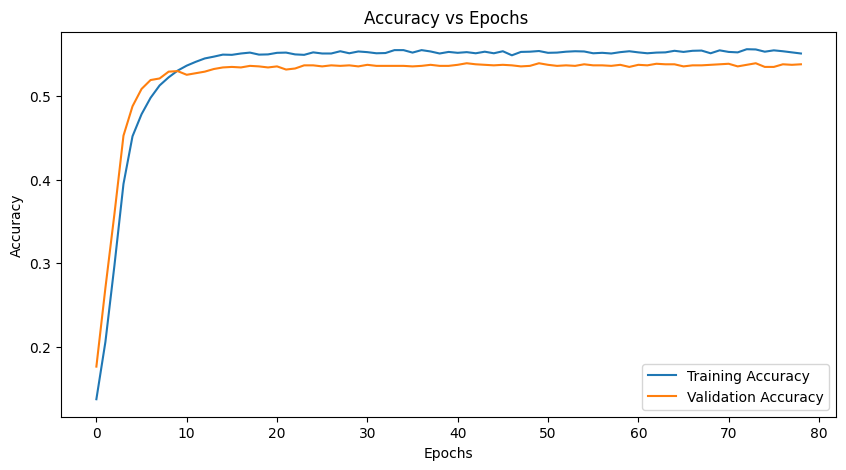

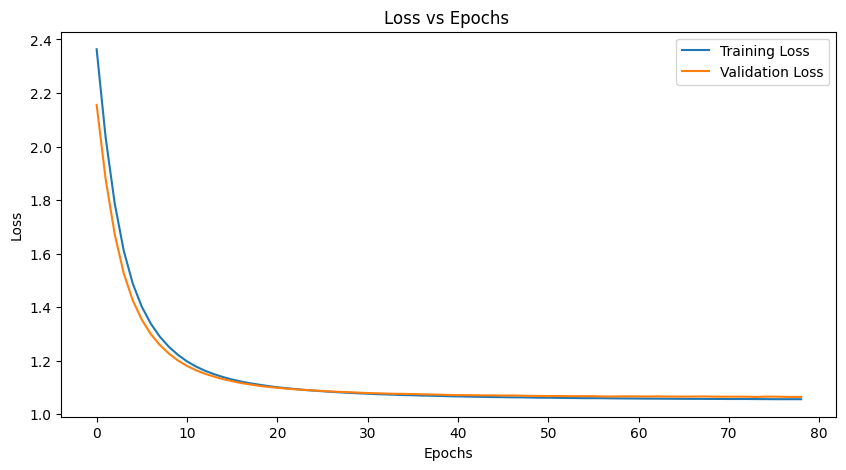

The layers of the model:
core.dense.Dense object at 0x7e15a21a1b10>
----------------------------------------------------



In [ ]:
plot_history(history)

<small> We look at validation accuracy and see that it's pretty low in a simple neural network. But the training curve for loss shows that the model does not show any signs of overfitting or underfitting.

## Model 2:
<small> Adding one hidden layer to basic model 1.

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 4s - loss: 1.2905 - accuracy: 0.4984 - val_loss: 1.1073 - val_accuracy: 0.5313 - 4s/epoch - 32ms/step
Epoch 2/200
117/117 - 1s - loss: 1.1012 - accuracy: 0.5561 - val_loss: 1.0696 - val_accuracy: 0.5564 - 822ms/epoch - 7ms/step
Epoch 3/200
117/117 - 1s - loss: 1.0698 - accuracy: 0.5610 - val_loss: 1.0592 - val_accuracy: 0.5533 - 1s/epoch - 9ms/step
Epoch 4/200
117/117 - 1s - loss: 1.0544 - accuracy: 0.5583 - val_loss: 1.0503 - val_accuracy: 0.5564 - 1s/epoch - 9ms/step
Epoch 5/200
117/117 - 1s - loss: 1.0398 - accuracy: 0.5749 - val_loss: 1.0436 - val_accuracy: 0.5489 - 837ms/epoch - 7ms/step
Epoch 6/200
117/117 - 0s - loss: 1.0333 - accuracy: 0.5658 - val_loss: 1.0458 - val_accuracy: 0.5489 - 451ms/epoch - 4ms/step
Epoch 7/200
117/117 - 0s - loss: 1.0241 - accuracy: 0.5709 - val_loss: 1.0468 - val_accuracy: 0.5533 - 415ms/epoch - 4ms/step
Epoch 8/200
117/117 - 0s - loss: 1.0186 - accuracy: 0.5744 - val_loss: 1.0369 - val_accuracy: 0.5558 - 366ms/epoch - 3ms/step


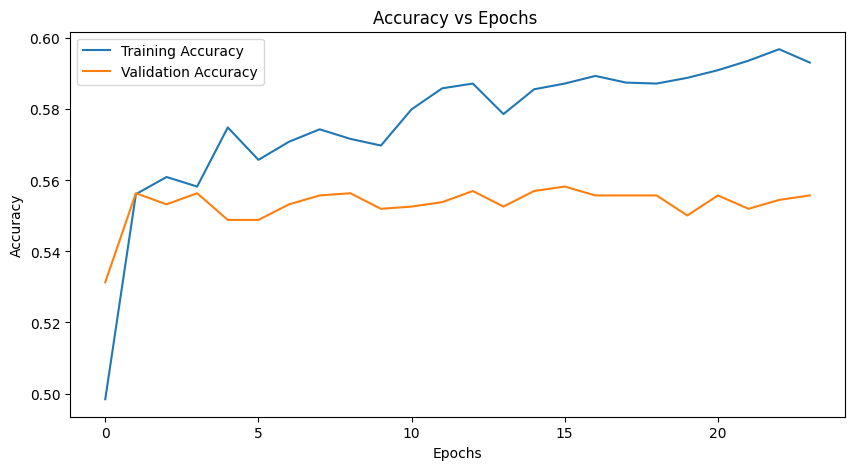

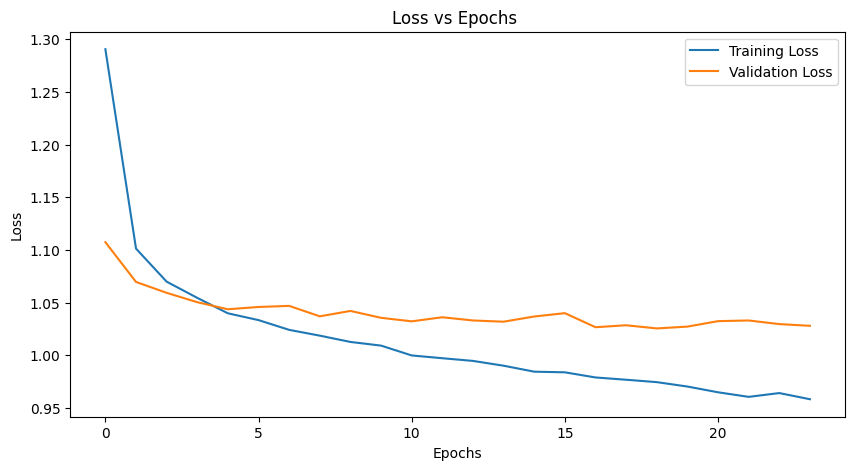

The layers of the model:
core.dense.Dense object at 0x7852a7735b40>
core.dense.Dense object at 0x7852a7735690>
----------------------------------------------------



In [ ]:
plot_history(history)

<small> The validation accuracy didn't improve much when we added the hidden layer. It's still pretty low. But when we observe the training curve, we can see the model overfitting.

## Model 3:
<small> Adding few hidden layers to basic model 1 and and early stopping regularisation method to control overfitting.

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=128, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
117/117 - 1s - loss: 1.2894 - accuracy: 0.4882 - val_loss: 1.1030 - val_accuracy: 0.5482 - 1s/epoch - 9ms/step
Epoch 2/200
117/117 - 0s - loss: 1.0981 - accuracy: 0.5593 - val_loss: 1.0674 - val_accuracy: 0.5489 - 262ms/epoch - 2ms/step
Epoch 3/200
117/117 - 0s - loss: 1.0665 - accuracy: 0.5564 - val_loss: 1.0509 - val_accuracy: 0.5558 - 260ms/epoch - 2ms/step
Epoch 4/200
117/117 - 0s - loss: 1.0475 - accuracy: 0.5666 - val_loss: 1.0505 - val_accuracy: 0.5533 - 252ms/epoch - 2ms/step
Epoch 5/200
117/117 - 0s - loss: 1.0298 - accuracy: 0.5693 - val_loss: 1.0520 - val_accuracy: 0.5570 - 238ms/epoch - 2ms/step
Epoch 6/200
117/117 - 0s - loss: 1.0232 - accuracy: 0.5720 - val_loss: 1.0353 - val_accuracy: 0.5576 - 334ms/epoch - 3ms/step
Epoch 7/200
117/117 - 0s - loss: 1.0139 - accuracy: 0.5795 - val_loss: 1.0426 - val_accuracy: 0.5639 - 269ms/epoch - 2ms/step
Epoch 8/200
117/117 - 0s - loss: 1.0047 - accuracy: 0.5808 - val_loss: 1.0394 - val_accuracy: 0.5551 - 246ms/epoch - 2ms/

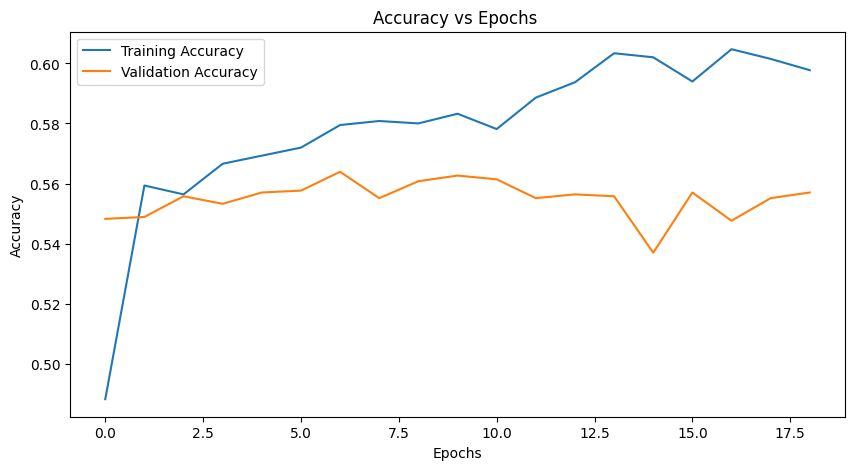

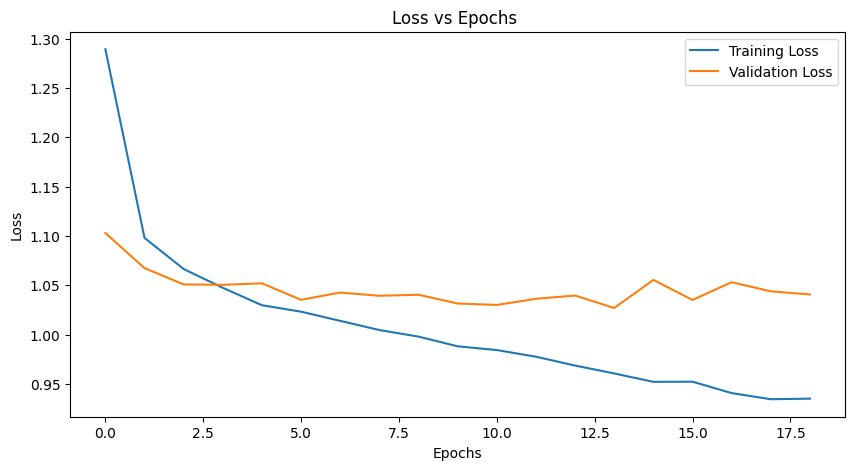

The layers of the model:
core.dense.Dense object at 0x7852a7ba81f0>
core.dense.Dense object at 0x7852a943e8c0>
core.dense.Dense object at 0x7852a943fac0>
----------------------------------------------------



In [ ]:
plot_history(history)

<small> Although the training accuracy improved, the learning curve shows that the model is overfitting again.

## Model 4:
<small> Adding more hidden layers

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units = 128, activation = "relu"),
    Dense(units=64, activation="relu"),
    Dense(units=7, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, batch_size=100, verbose=2, validation_data = (x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
38/38 - 1s - loss: 1.3450 - accuracy: 0.4758 - val_loss: 1.1146 - val_accuracy: 0.5244 - 1s/epoch - 36ms/step
Epoch 2/200
38/38 - 0s - loss: 1.1135 - accuracy: 0.5494 - val_loss: 1.0726 - val_accuracy: 0.5520 - 149ms/epoch - 4ms/step
Epoch 3/200
38/38 - 0s - loss: 1.0740 - accuracy: 0.5588 - val_loss: 1.0666 - val_accuracy: 0.5489 - 142ms/epoch - 4ms/step
Epoch 4/200
38/38 - 0s - loss: 1.0550 - accuracy: 0.5585 - val_loss: 1.0496 - val_accuracy: 0.5539 - 142ms/epoch - 4ms/step
Epoch 5/200
38/38 - 0s - loss: 1.0364 - accuracy: 0.5687 - val_loss: 1.0544 - val_accuracy: 0.5482 - 155ms/epoch - 4ms/step
Epoch 6/200
38/38 - 0s - loss: 1.0161 - accuracy: 0.5752 - val_loss: 1.0344 - val_accuracy: 0.5533 - 188ms/epoch - 5ms/step
Epoch 7/200
38/38 - 0s - loss: 1.0086 - accuracy: 0.5811 - val_loss: 1.0393 - val_accuracy: 0.5514 - 173ms/epoch - 5ms/step
Epoch 8/200
38/38 - 0s - loss: 0.9905 - accuracy: 0.5897 - val_loss: 1.0363 - val_accuracy: 0.5583 - 140ms/epoch - 4ms/step
Epoch 9/20

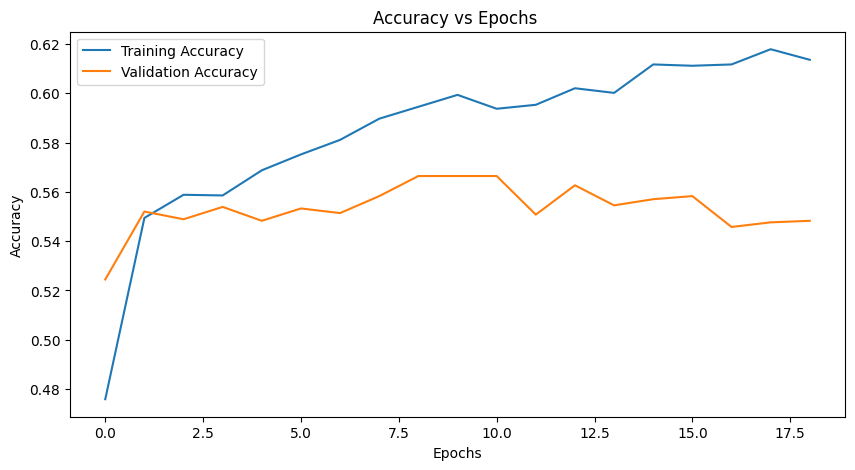

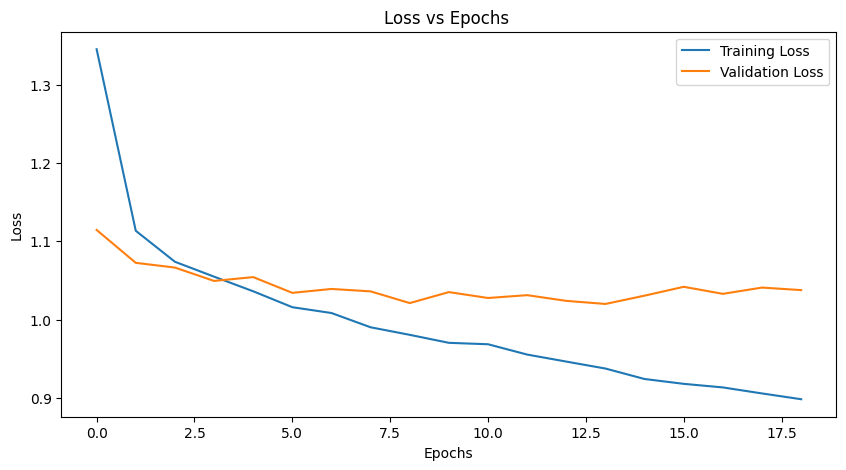

The layers of the model:
core.dense.Dense object at 0x7852a5ed7f10>
core.dense.Dense object at 0x7852a7a2ac50>
core.dense.Dense object at 0x7852a7becf10>
core.dense.Dense object at 0x7852a7b49030>
----------------------------------------------------



In [ ]:
plot_history(history)

<small> Again after adding new hidden layers, we see that training accuracy is increasing and not flattening suggesting that model could still get better accuracy with more data. This model also shows signs of overfitting the data

## **Findings**:  

We have observed that a simple neural network or multi-layer neural network does not perform well as we are only able to obtain a validation accuracy ~ 55%. In order to get a higher accuracy, we are considering to treat the above problem statement as a **BINARY CLASSIFICATION**.

# MODELS USING BINARY CLASSIFICATION: IS QUALITY GOOD OR BAD?

In [ ]:
# Defining binary column for quality. If quality is bigger than 5, the wine is good (1), else it's bad (0)

dataset['quality_binary'] = np.where(dataset['quality'] > 5, 1, 0)
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_binary,color_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0,1


In [ ]:
# we repeat the steps as we did above

continuous_data = dataset[numerical_features]
std_scalar = StandardScaler().fit(continuous_data)
std_continuous_data = std_scalar.transform(continuous_data)

categorical_data = dataset['color_binary'].to_numpy().reshape(-1,1)

In [ ]:
# defining target and features

y = dataset['quality_binary'] # target variable
x = np.append(categorical_data, std_continuous_data, axis=1)

print(y.shape)
print(x.shape)

(5320,)
(5320, 12)


In [ ]:
# splitting dataset into training and testing

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(x_train.shape, y_train.shape)

(3724, 12) (3724,)


### Model 1:

<small> Simple Neural Network

In [ ]:
model = Sequential([
     InputLayer(input_shape=(12,)),
     Dense(units=1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
94/94 [==============================] - 1s 4ms/step - loss: 0.7020 - accuracy: 0.6438 - val_loss: 0.6799 - val_accuracy: 0.6376
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.6466 - accuracy: 0.6586 - val_loss: 0.6362 - val_accuracy: 0.6550
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.6113 - accuracy: 0.6694 - val_loss: 0.6080 - val_accuracy: 0.6752
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5885 - accuracy: 0.6841 - val_loss: 0.5885 - val_accuracy: 0.6926
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.6972 - val_loss: 0.5752 - val_accuracy: 0.6993
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5626 - accuracy: 0.7002 - val_loss: 0.5650 - val_accuracy: 0.7074
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.7096 - val_loss: 0.5568 - val_accuracy: 0.7195
Epoch 8/100
9

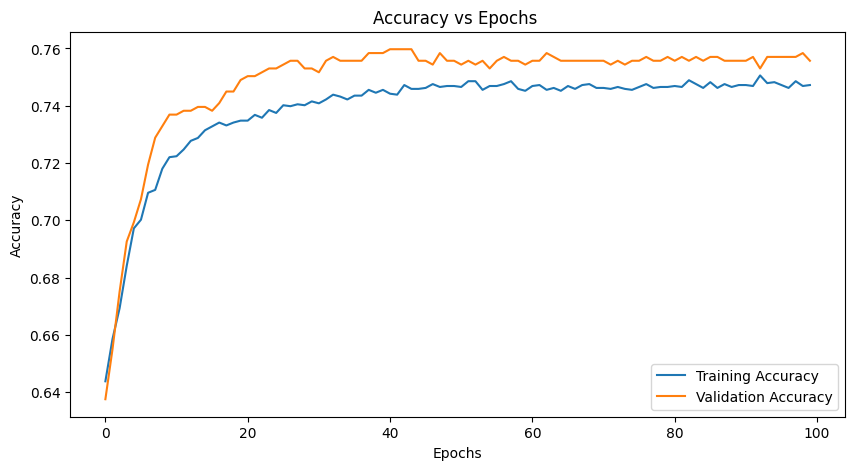

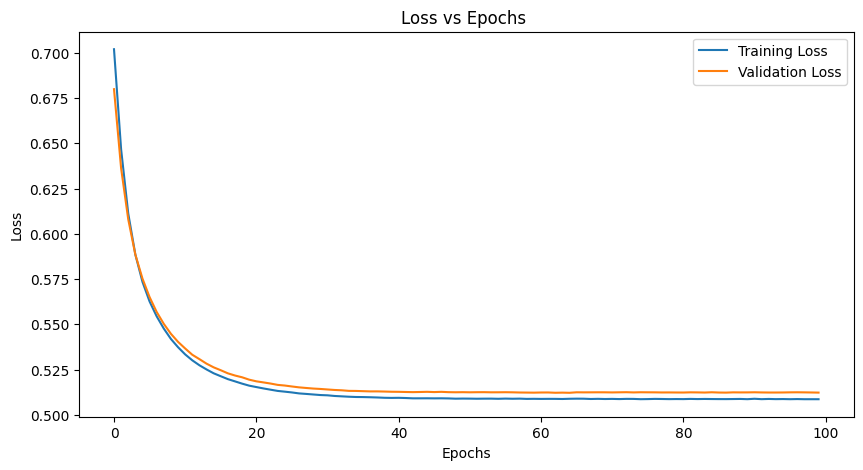

The layers of the model:
core.dense.Dense object at 0x7d8486e31930>
----------------------------------------------------



In [ ]:
plot_history(history)

<small>We already see that the validation accuracy is way higher with binary classification than multiclass classification, even with a simple neural network. The training curves also indicate no signs of underfitting or overfitting

### Model 2:
<small> Adding one hidden layer

In [ ]:
# Let's add a hidden layers

model = Sequential([
     InputLayer(input_shape=(12,)), # nr of features
     Dense(units=10, activation="relu"),
     Dense(units=1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
94/94 [==============================] - 1s 4ms/step - loss: 0.6984 - accuracy: 0.5713 - val_loss: 0.6482 - val_accuracy: 0.6228
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6485 - val_loss: 0.5905 - val_accuracy: 0.6658
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.6707 - val_loss: 0.5658 - val_accuracy: 0.6953
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.6965 - val_loss: 0.5519 - val_accuracy: 0.7141
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5339 - accuracy: 0.7147 - val_loss: 0.5422 - val_accuracy: 0.7356
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5254 - accuracy: 0.7288 - val_loss: 0.5352 - val_accuracy: 0.7369
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.5184 - accuracy: 0.7308 - val_loss: 0.5287 - val_accuracy: 0.7409
Epoch 8/100
9

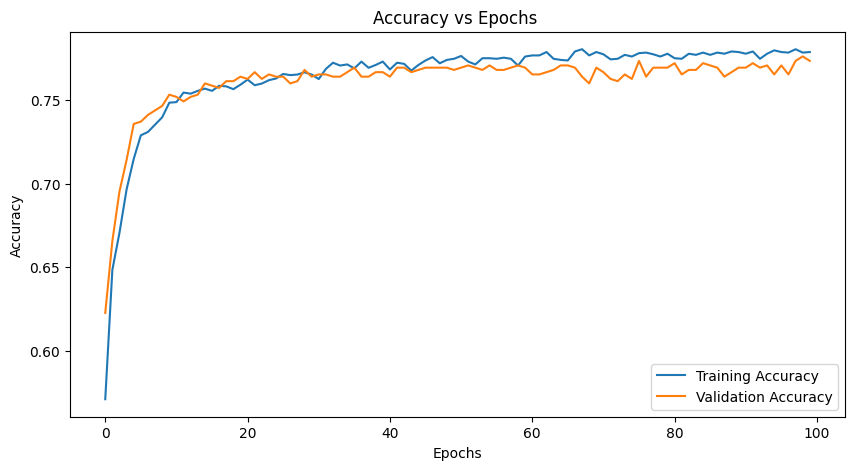

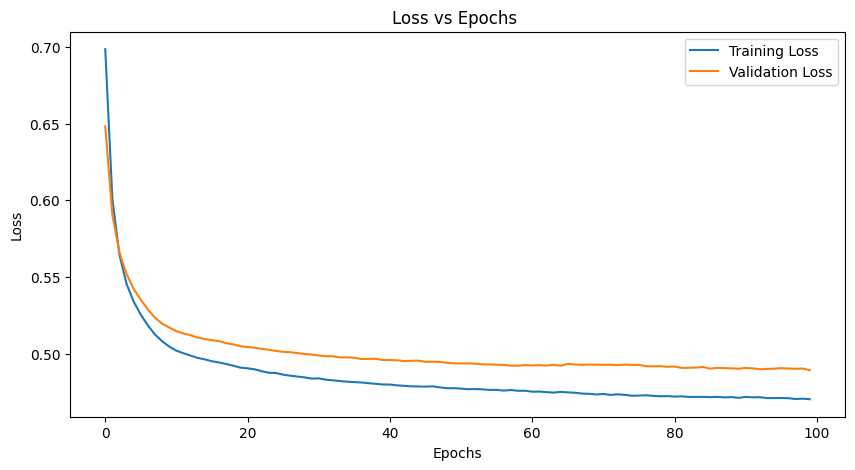

The layers of the model:
core.dense.Dense object at 0x7d8484609150>
core.dense.Dense object at 0x7d84872bfe50>
----------------------------------------------------



In [ ]:
plot_history(history)

<small>Adding a new hidden layer improves the validation accuracy ~77%.Adding a new layer didn't improve validation accuracy but started overfitting the model.

### Model 3:
<small>Adding regularisation techniques like the Early Stopping

In [ ]:
# We'll try to improve validation accuracy by increasing accuracy and adding Early Stopping to prevent overfitting

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

model = Sequential([
     InputLayer(input_shape=(12,)), # nr of features
     Dense(units=10, activation="relu"),
     Dense(units=1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100000, batch_size = 200, validation_split = 0.2,callbacks=[callback])

Epoch 1/100000
15/15 [==============================] - 1s 35ms/step - loss: 0.6236 - accuracy: 0.6459 - val_loss: 0.6130 - val_accuracy: 0.6591
Epoch 2/100000
15/15 [==============================] - 0s 23ms/step - loss: 0.6063 - accuracy: 0.6667 - val_loss: 0.5967 - val_accuracy: 0.6859
Epoch 3/100000
15/15 [==============================] - 0s 9ms/step - loss: 0.5912 - accuracy: 0.6828 - val_loss: 0.5838 - val_accuracy: 0.6966
Epoch 4/100000
15/15 [==============================] - 0s 11ms/step - loss: 0.5796 - accuracy: 0.6915 - val_loss: 0.5730 - val_accuracy: 0.7060
Epoch 5/100000
15/15 [==============================] - 0s 26ms/step - loss: 0.5696 - accuracy: 0.6959 - val_loss: 0.5640 - val_accuracy: 0.7020
Epoch 6/100000
15/15 [==============================] - 0s 22ms/step - loss: 0.5615 - accuracy: 0.7036 - val_loss: 0.5562 - val_accuracy: 0.7114
Epoch 7/100000
15/15 [==============================] - 0s 17ms/step - loss: 0.5542 - accuracy: 0.7116 - val_loss: 0.5495 - val_acc

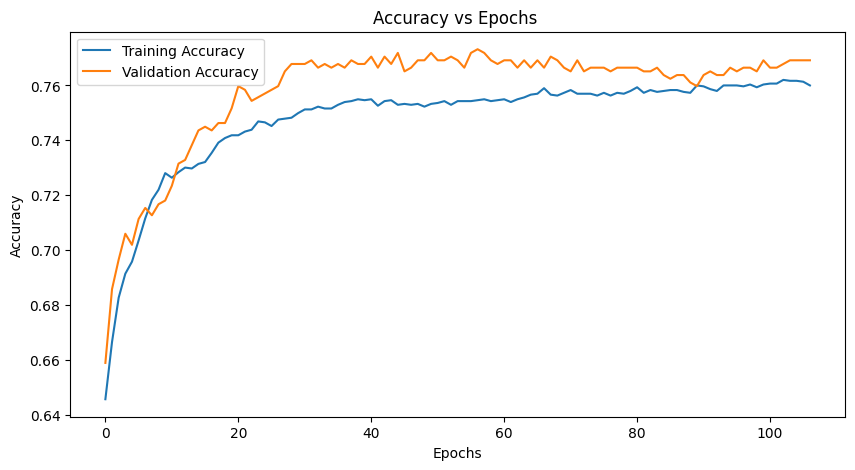

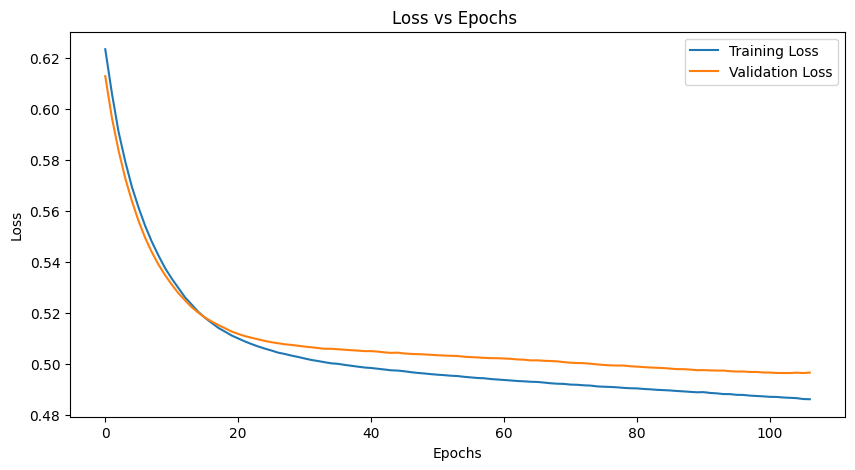

The layers of the model:
core.dense.Dense object at 0x7d847cf12980>
core.dense.Dense object at 0x7d847cf12a10>
----------------------------------------------------



In [ ]:
plot_history(history)

<small>Validation accuracy is the same when we introduced early stopping, with accuracy score ~ 76%. The training curves also show that the model has no signs of underfitting or overfitting.

### Model 4:
<small>Adding more hidden layers

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dense(units = 128, activation = "relu"),
    Dense(units=64, activation="relu"),
    Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=1000, batch_size=200, verbose=2, validation_split = 0.2 , callbacks=[early_stopping])

Epoch 1/1000
15/15 - 1s - loss: 0.5826 - accuracy: 0.6878 - val_loss: 0.5184 - val_accuracy: 0.7503 - 1s/epoch - 96ms/step
Epoch 2/1000
15/15 - 0s - loss: 0.5077 - accuracy: 0.7449 - val_loss: 0.5059 - val_accuracy: 0.7517 - 139ms/epoch - 9ms/step
Epoch 3/1000
15/15 - 0s - loss: 0.4927 - accuracy: 0.7566 - val_loss: 0.4942 - val_accuracy: 0.7732 - 148ms/epoch - 10ms/step
Epoch 4/1000
15/15 - 0s - loss: 0.4802 - accuracy: 0.7697 - val_loss: 0.4889 - val_accuracy: 0.7718 - 151ms/epoch - 10ms/step
Epoch 5/1000
15/15 - 0s - loss: 0.4710 - accuracy: 0.7754 - val_loss: 0.4914 - val_accuracy: 0.7705 - 146ms/epoch - 10ms/step
Epoch 6/1000
15/15 - 0s - loss: 0.4681 - accuracy: 0.7764 - val_loss: 0.4875 - val_accuracy: 0.7705 - 159ms/epoch - 11ms/step
Epoch 7/1000
15/15 - 0s - loss: 0.4638 - accuracy: 0.7788 - val_loss: 0.4910 - val_accuracy: 0.7732 - 143ms/epoch - 10ms/step
Epoch 8/1000
15/15 - 0s - loss: 0.4586 - accuracy: 0.7855 - val_loss: 0.4815 - val_accuracy: 0.7772 - 155ms/epoch - 10ms/s

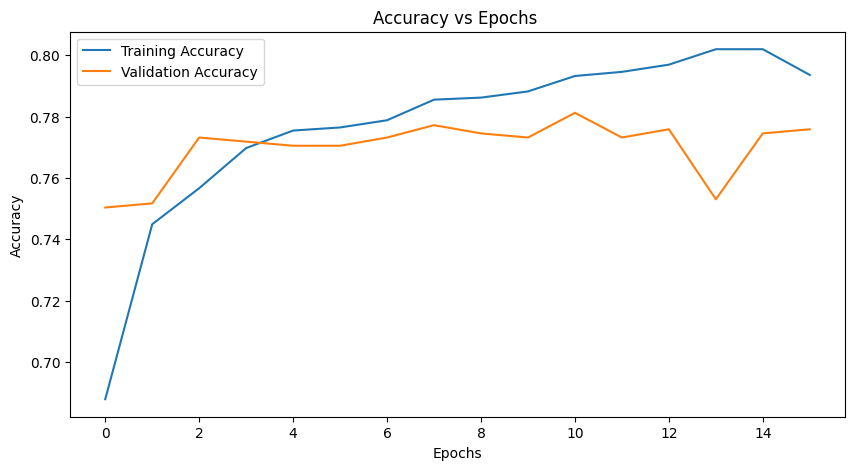

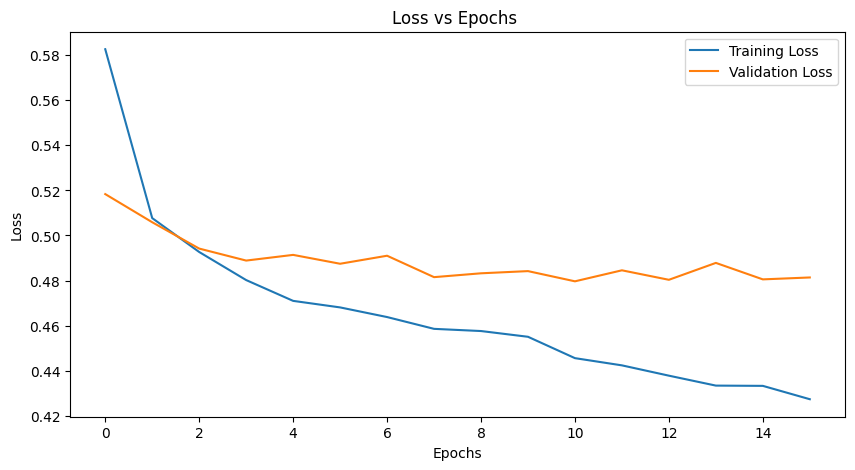

The layers of the model:
core.dense.Dense object at 0x7d847cfe09d0>
core.dense.Dense object at 0x7d847cfe1630>
core.dense.Dense object at 0x7d847cfe0880>
core.dense.Dense object at 0x7d847cfe0970>
----------------------------------------------------



In [ ]:
plot_history(history)

<small> This model performs worse than the previous model. It's accuracy is close to the previous model's but the training curve indicates that it's not a good fit. The training loss curve seems to be descreasing.

From our previous findings, we saw that the problem why we're getting a low score may be the imbalanced dataset. In this stage, we will try SMOTE sampling technique, which is a statistical technique used to increase the number of cases in our dataset in a balanced way by creating synthetic samples from the minority class.

# Using SMOTE sampling technique on BINARY CLASSIFICATION

In [ ]:
dataset_6_classes = dataset[(dataset.quality< 9)].reset_index()
dataset_6_classes.dropna(inplace=True)
print(dataset.shape, dataset_6_classes.shape)

x_dataset = dataset_6_classes.drop(columns=['quality'])
y_dataset = dataset_6_classes[['quality']]
y_dataset = pd.DataFrame(np.where(y_dataset <= 5, 0, 1), columns=['quality_updated'])

scaler = StandardScaler()
names = numerical_features
d = scaler.fit_transform(x_dataset[names])
scaled_features = pd.concat([pd.DataFrame(d, columns=names), x_dataset['color_binary']],axis=1)
display(scaled_features)

display(scaled_features.shape, y_dataset.shape)

(5320, 14) (5315, 15)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_binary
0,0.140175,2.114265,-2.163534,-0.699762,0.523050,-1.068839,-1.410514,1.100518,1.779361,0.177476,-0.968532,1
1,0.443234,3.183795,-2.163534,-0.544227,1.119812,-0.282659,-0.829456,0.763123,-0.153271,0.978740,-0.630978,1
2,0.443234,2.470775,-1.891759,-0.610885,0.957058,-0.844216,-1.058357,0.830602,0.220787,0.778424,-0.630978,1
3,3.019232,-0.381306,1.641307,-0.699762,0.495925,-0.731905,-0.952711,1.167997,-0.402643,0.311020,-0.630978,1
4,0.140175,1.876591,-2.163534,-0.721981,0.495925,-0.956527,-1.304867,1.100518,1.779361,0.177476,-0.968532,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5310,-0.769001,-0.797234,-0.193169,-0.766420,-0.480594,-0.338815,-0.389260,-1.146533,0.283130,-0.223155,0.550459,0
5311,-0.465942,-0.143633,0.282436,0.655612,-0.263590,1.514323,0.948934,0.122072,-0.464986,-0.490243,-0.799755,0
5312,-0.541707,-0.618979,-0.872605,-0.855297,-0.426343,-0.001881,-0.054712,-0.674180,-1.462473,-0.490243,-0.968532,0
5313,-1.299353,-0.321888,-0.125226,-0.877516,-0.941727,-0.563438,-0.072320,-1.973151,0.719530,-1.024419,1.900674,0


(5315, 12)

(5315, 1)

#### Determining the optimal kneighbours for SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Creating a pipeline with SMOTE and a classifier (RandomForest)
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier())
])

# Defining parameter grid
param_grid = {
    'smote__k_neighbors': [2,3,4,5,6,7],
    'classifier__n_estimators': [300]
}

# Performing grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=['roc_auc', "accuracy"], refit='roc_auc', verbose=11)  # Use an appropriate scoring metric
grid_search.fit(scaled_features, y_dataset)

# Getting the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START classifier__n_estimators=300, smote__k_neighbors=2..........
[CV 1/3; 1/6] END classifier__n_estimators=300, smote__k_neighbors=2; accuracy: (test=0.565) roc_auc: (test=0.765) total time=   3.5s
[CV 2/3; 1/6] START classifier__n_estimators=300, smote__k_neighbors=2..........
[CV 2/3; 1/6] END classifier__n_estimators=300, smote__k_neighbors=2; accuracy: (test=0.719) roc_auc: (test=0.777) total time=   3.2s
[CV 3/3; 1/6] START classifier__n_estimators=300, smote__k_neighbors=2..........
[CV 3/3; 1/6] END classifier__n_estimators=300, smote__k_neighbors=2; accuracy: (test=0.744) roc_auc: (test=0.824) total time=   3.2s
[CV 1/3; 2/6] START classifier__n_estimators=300, smote__k_neighbors=3..........
[CV 1/3; 2/6] END classifier__n_estimators=300, smote__k_neighbors=3; accuracy: (test=0.559) roc_auc: (test=0.766) total time=   3.8s
[CV 2/3; 2/6] START classifier__n_estimators=300, smote__k_neighbors=3..........

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)

final_features, final_labels =  oversample.fit_resample(scaled_features, y_dataset)

display(final_features.head())
display(final_labels.head())
print(final_labels.value_counts())
print(final_features.shape, final_labels.shape)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_binary
0,0.140175,2.114265,-2.163534,-0.699762,0.523050,-1.068839,-1.410514,1.100518,1.779361,0.177476,-0.968532,1
1,0.443234,3.183795,-2.163534,-0.544227,1.119812,-0.282659,-0.829456,0.763123,-0.153271,0.978740,-0.630978,1
2,0.443234,2.470775,-1.891759,-0.610885,0.957058,-0.844216,-1.058357,0.830602,0.220787,0.778424,-0.630978,1
3,3.019232,-0.381306,1.641307,-0.699762,0.495925,-0.731905,-0.952711,1.167997,-0.402643,0.311020,-0.630978,1
4,0.140175,1.876591,-2.163534,-0.721981,0.495925,-0.956527,-1.304867,1.100518,1.779361,0.177476,-0.968532,1


,quality_updated
0,0
1,0
2,0
3,1
4,0


quality_updated
0                  3327
1                  3327
dtype: int64
(6654, 12) (6654, 1)


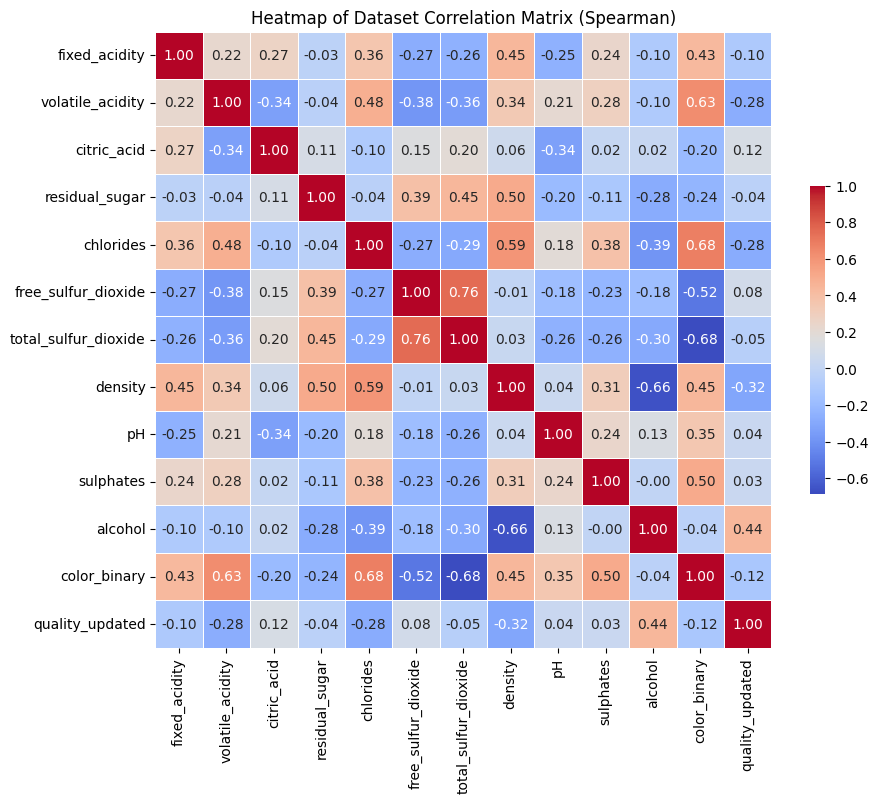

In [ ]:
updated_dataset = pd.concat([final_features, final_labels], axis=1)

upd_dataset_correlations = updated_dataset.corr(method='spearman', numeric_only = True)

plt.figure(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(upd_dataset_correlations, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Heatmap of Dataset Correlation Matrix (Spearman)')
plt.show()

In [ ]:
# we split the dataset into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(final_features, final_labels, test_size=0.3,random_state=42)

In [ ]:
# We also add ReduceLROnPlateau callback to reduce the learning rate during training to avoid overshooting minima
# We try l2 regularization to prevent overfitting by penalizing large weights
# We use dropout to prevent overfitting and create more robust features

from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

model = Sequential([
    InputLayer(input_shape=(12,)),
    # Dense(units = 128, activation = "relu"),
    Dense(units = 64, activation = "relu", kernel_regularizer = l2(0.02)),
    Dropout(0.6),
    Dense(units = 32, activation="relu"),
    Dropout(0.6),
    Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)

history = model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=2,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/200
73/73 - 1s - loss: 1.0379 - accuracy: 0.5712 - val_loss: 0.8883 - val_accuracy: 0.6970 - lr: 0.0010 - 1s/epoch - 17ms/step
Epoch 2/200
73/73 - 0s - loss: 0.8615 - accuracy: 0.6446 - val_loss: 0.7722 - val_accuracy: 0.7216 - lr: 0.0010 - 205ms/epoch - 3ms/step
Epoch 3/200
73/73 - 0s - loss: 0.7700 - accuracy: 0.6805 - val_loss: 0.6968 - val_accuracy: 0.7311 - lr: 0.0010 - 213ms/epoch - 3ms/step
Epoch 4/200
73/73 - 0s - loss: 0.6975 - accuracy: 0.7000 - val_loss: 0.6428 - val_accuracy: 0.7401 - lr: 0.0010 - 214ms/epoch - 3ms/step
Epoch 5/200
73/73 - 0s - loss: 0.6514 - accuracy: 0.7151 - val_loss: 0.6065 - val_accuracy: 0.7396 - lr: 0.0010 - 183ms/epoch - 3ms/step
Epoch 6/200
73/73 - 0s - loss: 0.6221 - accuracy: 0.7241 - val_loss: 0.5823 - val_accuracy: 0.7411 - lr: 0.0010 - 192ms/epoch - 3ms/step
Epoch 7/200
73/73 - 0s - loss: 0.5983 - accuracy: 0.7303 - val_loss: 0.5687 - val_accuracy: 0.7451 - lr: 0.0010 - 207ms/epoch - 3ms/step
Epoch 8/200
73/73 - 0s - loss: 0.5924 - acc

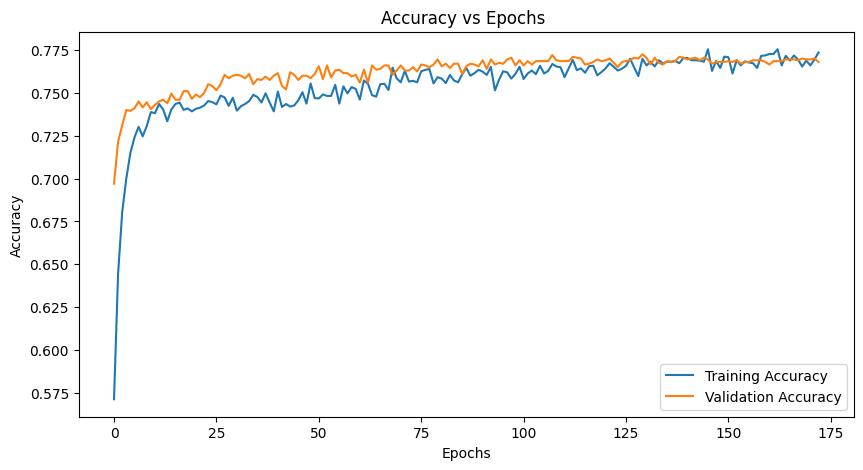

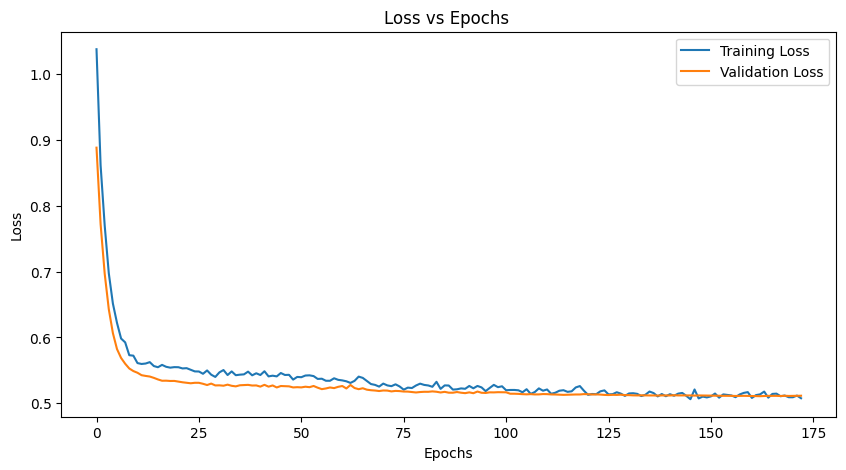

The layers of the model:
core.dense.Dense object at 0x7d848970b340>
regularization.dropout.Dropout object at 0x7d8489709150>
core.dense.Dense object at 0x7d848970a080>
regularization.dropout.Dropout object at 0x7d8489709570>
core.dense.Dense object at 0x7d8489761db0>
----------------------------------------------------



In [ ]:
plot_history(history)

We see the SMOTE technique improved validation accuracy on the Multiclass Classification problem.

In [ ]:
# We try more units in input layers

from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

model_2 = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dropout(0.4),
    Dense(units=128, activation="relu", kernel_regularizer=l2(1)),
    Dropout(0.4),
    Dense(units=64, activation="relu"),
    Dropout(0.4),
    Dense(units=1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model_2.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=10, monitor='val_loss', factor=0.8)

history_2 = model_2.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_data = (X_test, y_test), callbacks=[early_stopping, reduce_lr])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               3328      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                

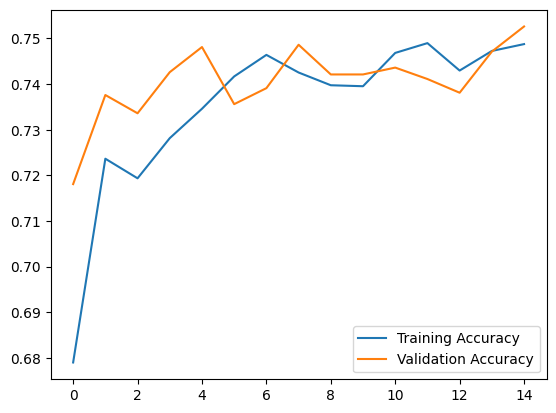

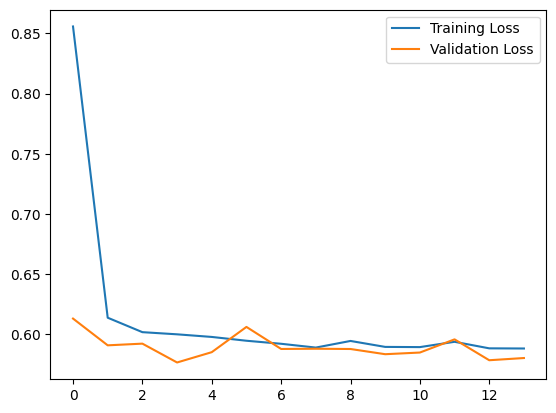

In [ ]:
plot_history(history_2)

<small>Overall, validation accuracy is about ~75% for SMOTE sampling technique on Binary Classification. Let's see how SMOTE technique does on Multiclass Classification.

# Using SMOTE sampling technique on MULTICLASS CLASSIFICATION

In [ ]:
dataset_6_classes = dataset[(dataset.quality< 9)].reset_index()
dataset_6_classes.dropna(inplace=True)
print(dataset.shape, dataset_6_classes.shape)

x_dataset = dataset_6_classes.drop(columns=['quality'])
y_dataset = dataset_6_classes[['quality']] - 3

scaler = StandardScaler()
names = numerical_features
d = scaler.fit_transform(x_dataset[names])
scaled_features = pd.concat([pd.DataFrame(d, columns=names), x_dataset['color_binary']],axis=1)

display(scaled_features.shape, y_dataset.shape)

(5320, 14) (5315, 15)


(5315, 12)

(5315, 1)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=6)

final_features, final_labels =  oversample.fit_resample(scaled_features, y_dataset)
final_labels_cat = to_categorical(final_labels, num_classes=6)

print(final_features.shape, final_labels.shape)

(13938, 12) (13938, 1)


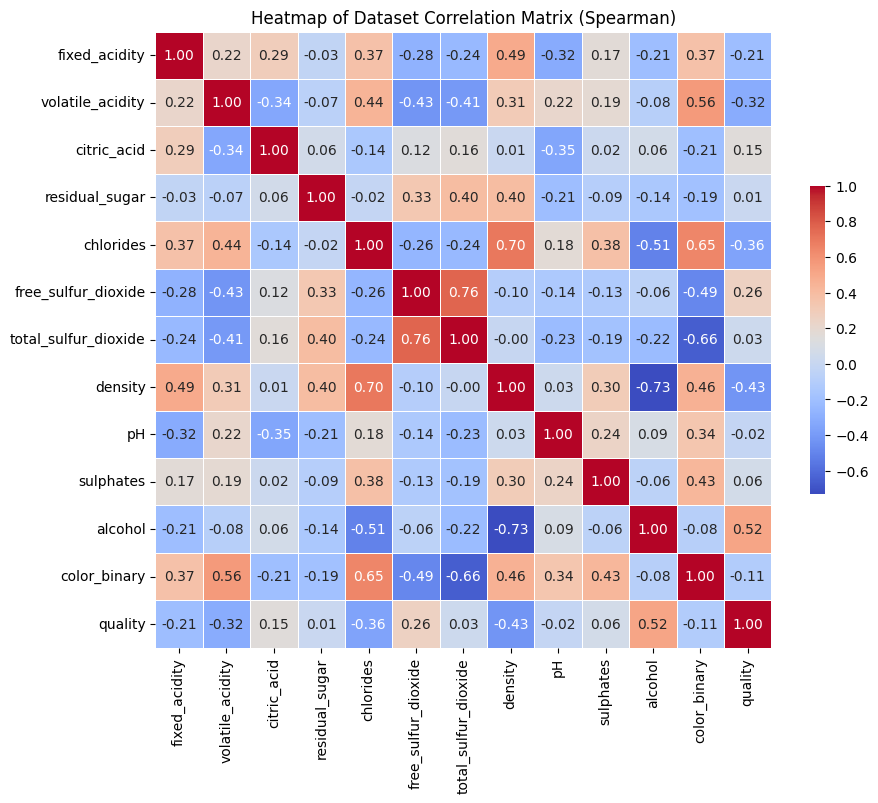

In [ ]:
updated_dataset = pd.concat([final_features, final_labels], axis=1)

upd_dataset_correlations = updated_dataset.corr(method='spearman', numeric_only = True)

plt.figure(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(upd_dataset_correlations, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Heatmap of Dataset Correlation Matrix (Spearman)')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(final_features, final_labels_cat, test_size=0.3,random_state=42)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    # Dense(units = 128, activation = "relu"),
    Dense(units = 64, activation = "relu"),
    Dropout(0.1),
    Dense(units = 32, activation="relu"),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=2,
                    validation_data = (X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/200
153/153 - 1s - loss: 1.5187 - accuracy: 0.3472 - val_loss: 1.3520 - val_accuracy: 0.4402 - 1s/epoch - 9ms/step
Epoch 2/200
153/153 - 0s - loss: 1.2903 - accuracy: 0.4567 - val_loss: 1.2314 - val_accuracy: 0.4950 - 426ms/epoch - 3ms/step
Epoch 3/200
153/153 - 0s - loss: 1.2084 - accuracy: 0.4952 - val_loss: 1.1711 - val_accuracy: 0.5213 - 358ms/epoch - 2ms/step
Epoch 4/200
153/153 - 0s - loss: 1.1565 - accuracy: 0.5157 - val_loss: 1.1274 - val_accuracy: 0.5297 - 417ms/epoch - 3ms/step
Epoch 5/200
153/153 - 0s - loss: 1.1250 - accuracy: 0.5334 - val_loss: 1.0968 - val_accuracy: 0.5469 - 427ms/epoch - 3ms/step
Epoch 6/200
153/153 - 0s - loss: 1.0891 - accuracy: 0.5531 - val_loss: 1.0710 - val_accuracy: 0.5617 - 414ms/epoch - 3ms/step
Epoch 7/200
153/153 - 0s - loss: 1.0656 - accuracy: 0.5604 - val_loss: 1.0453 - val_accuracy: 0.5725 - 413ms/epoch - 3ms/step
Epoch 8/200
153/153 - 0s - loss: 1.0452 - accuracy: 0.5725 - val_loss: 1.0236 - val_accuracy: 0.5789 - 407ms/epoch - 3ms/

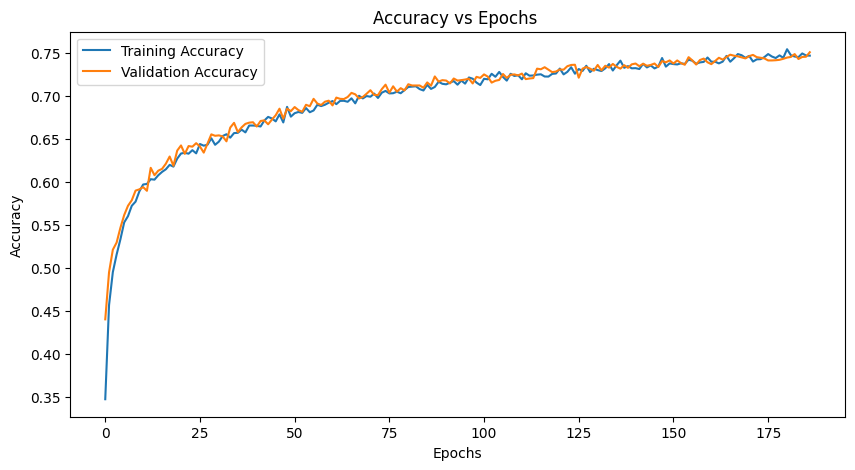

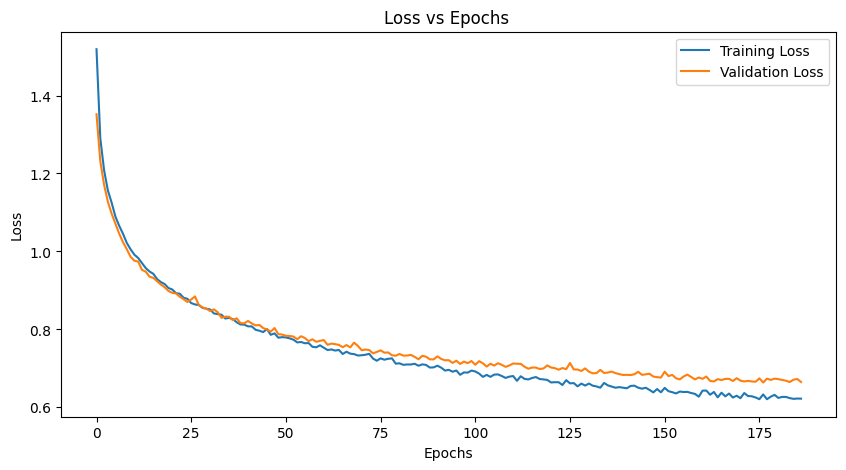

The layers of the model:
core.dense.Dense object at 0x7d848971a9b0>
regularization.dropout.Dropout object at 0x7d8489719e40>
core.dense.Dense object at 0x7d84897339d0>
core.dense.Dense object at 0x7d84897317e0>
----------------------------------------------------



In [ ]:
plot_history(history)

We see the SMOTE technique improved validation accuracy on the Multiclass Classification problem.

In [ ]:
# We try more layers

from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

model_2 = Sequential([
    InputLayer(input_shape=(12,)),
    Dense(units=256, activation="relu"),
    Dropout(0.4),
    Dense(units=128, activation="relu", kernel_regularizer=l2(0.1)),
    Dropout(0.4),
    Dense(units=64, activation="relu"),
    Dense(units=6, activation="softmax")
])

model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model_2.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=10, monitor='val_loss', factor=0.1)

history_2 = model_2.fit(X_train, y_train, epochs=200, batch_size=64, verbose=2, validation_split = 0.3, callbacks=[early_stopping, reduce_lr ])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 256)               3328      
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 6)                 390       
                                                                 
Total params: 44870 (175.27 KB)
Trainable params: 448

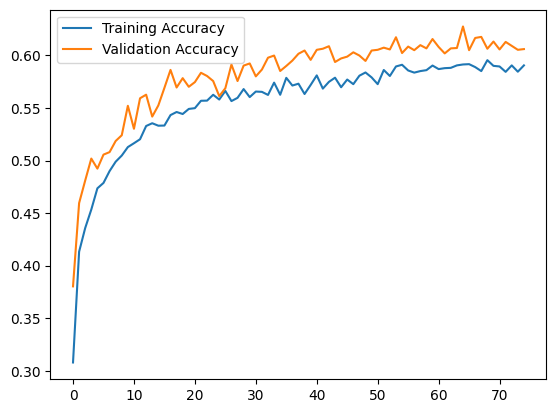

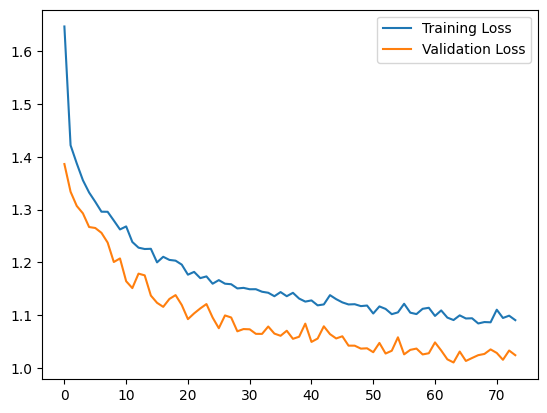

In [ ]:
plt.figure()
plt.plot(history_2.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(history_2.history['loss'][1:], label = 'Training Loss')
plt.plot(history_2.history['val_loss'][1:], label = 'Validation Loss')
plt.legend()

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print("Test data loss :", results[0])
print("Test accuracy :", np.round(results[1] * 100, 2), "%")

131/131 - 0s - loss: 0.6638 - accuracy: 0.7418 - 284ms/epoch - 2ms/step
Test data loss : 0.6637869477272034
Test accuracy : 74.18 %


## QUESTION 1: The Final model (A single model for both white and red wine.)


It is selected based on the below two criteria

1. Model does not overfit/ underfit the dataset based on the training and validation data
2. Model with the highest test data accuracy

**FINAL MODEL**:

The model with the following preprocessing and architecture is selected -

1. Multi-class classification from quality values - 3 to 8
2. SMOTE oversampling technique to ensure the classes are balanced
3. The below dense layer architecture -

**Model: "sequential_16"**
_______________________________
 Layer (type)&emsp;&emsp;&emsp;&emsp;Output Shape&emsp;&emsp;&emsp;&emsp;Param #   
\========================================================================

 dense_47 (Dense)&emsp;&emsp;&emsp;&emsp;(None, 64)&emsp;&emsp;&emsp;&emsp;832       
                                                           
 dropout_13 (Dropout)&emsp;&emsp;&emsp;(None, 64)&emsp;&emsp;&emsp;&emsp;0         
                                                            
 dense_48 (Dense)&emsp;&emsp;&emsp;&emsp;(None, 32)&emsp;&emsp;&emsp;&emsp;2080      
                                                               
 dense_49 (Dense)&emsp;&emsp;&emsp;&emsp;(None, 6)&emsp;&emsp;&emsp;&emsp;198       

================================================================= <br>
Total params: 3110 (12.15 KB)<br>
Trainable params: 3110 (12.15 KB)<br>
Non-trainable params: 0 (0.00 Byte)<br>
_________________________________________________________________


#### DATA PREPROCESSING

In [ ]:
dataset_6_classes = dataset[(dataset.quality< 9)].reset_index()
dataset_6_classes.dropna(inplace=True)
print(dataset.shape, dataset_6_classes.shape)

x_dataset = dataset_6_classes.drop(columns=['quality'])
y_dataset = dataset_6_classes[['quality']] - 3

scaler = StandardScaler()
names = numerical_features
d = scaler.fit_transform(x_dataset[names])
scaled_features = pd.concat([pd.DataFrame(d, columns=names), x_dataset['color_binary']],axis=1)

display(scaled_features.shape, y_dataset.shape)


from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=6)

final_features, final_labels =  oversample.fit_resample(scaled_features, y_dataset)
final_labels_cat = to_categorical(final_labels, num_classes=6)

print(final_features.shape, final_labels.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(final_features, final_labels_cat, test_size=0.3,random_state=42)
print("TRAINING DATA SHAPE : ", X_train.shape, y_train.shape)
print("TEST DATA SHAPE : ", X_test.shape, y_test.shape)

y_test_upd = y_test
test_dataset = pd.DataFrame(np.append(X_test,y_test_upd, axis=1), columns=list(scaled_features.columns) + ['quality_upd' + str(i) for i in range(6)])
test_dataset.head()

(5320, 14) (5315, 15)


(5315, 12)

(5315, 1)

(13938, 12) (13938, 1)
TRAINING DATA SHAPE :  (9756, 12) (9756, 6)
TEST DATA SHAPE :  (4182, 12) (4182, 6)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_binary,quality_upd0,quality_upd1,quality_upd2,quality_upd3,quality_upd4,quality_upd5
0,0.870786,3.456849,-0.738413,-0.673579,0.751984,-1.324219,-1.623488,0.556990,0.289080,-0.478330,-0.554644,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.068470,-0.260358,-0.416966,-0.562286,-0.390282,-0.392975,0.206108,0.222666,3.194929,0.557696,-0.745162,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.025135,0.365596,-0.229670,-0.619326,-0.670472,-0.268739,-0.683499,-1.889359,-1.595915,-1.289303,2.105719,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.338334,-0.902018,0.058947,-0.647722,-0.374241,-0.232435,-0.228465,-0.734741,0.827826,1.122864,0.474985,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.025030,-0.368964,0.787522,-0.448637,-0.742128,-1.405773,-1.553704,-0.627842,-0.751979,-1.385991,0.489973,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### MODEL TRAINING AND EVALUATION

In [ ]:
model = Sequential([
    InputLayer(input_shape=(12,)),
    # Dense(units = 128, activation = "relu"),
    Dense(units = 64, activation = "relu"),
    Dropout(0.1),
    Dense(units = 32, activation="relu"),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=2,
                    validation_split = 0.3,
                    callbacks=[early_stopping])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                832       
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 6)                 198       
                                                                 
Total params: 3110 (12.15 KB)
Trainable params: 3110 (12.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/200
107/107 - 3s - loss: 1.6122 - accuracy: 0.3063 - val_loss: 1.4351 - val_accuracy: 0.4018 - 3s/epoch - 27ms/step
Epoch 2/200
107/107 - 

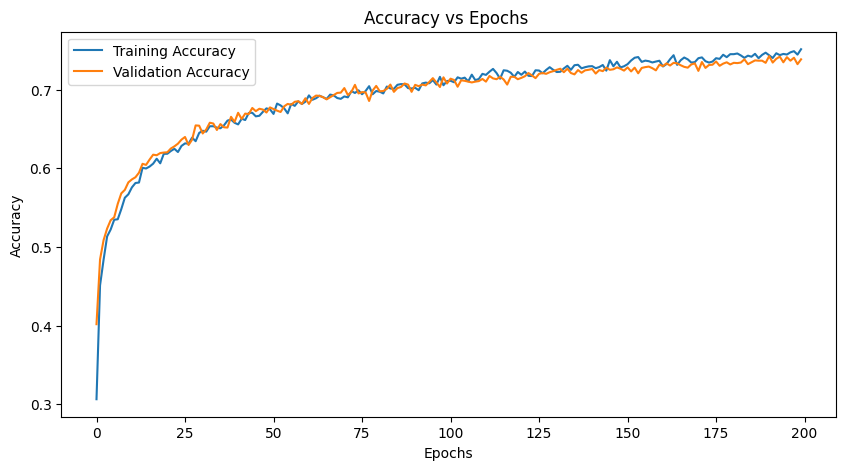

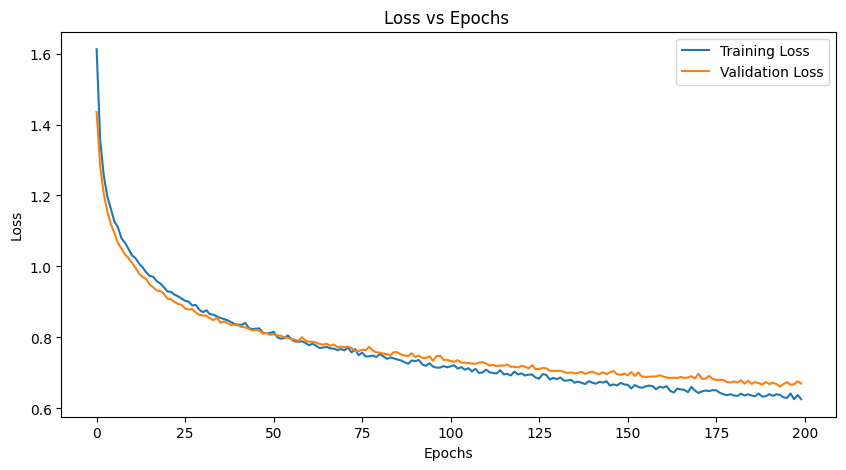

The layers of the model:
core.dense.Dense object at 0x7d8487308e80>
regularization.dropout.Dropout object at 0x7d848730a4a0>
core.dense.Dense object at 0x7d848730b4f0>
core.dense.Dense object at 0x7d848730b940>
----------------------------------------------------



In [ ]:
plot_history(history)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=2)
print("Test data loss :", results[0])
print("Test accuracy :", np.round(results[1] * 100, 2), "%")

131/131 - 0s - loss: 0.7068 - accuracy: 0.7327 - 168ms/epoch - 1ms/step
Test data loss : 0.7068332433700562
Test accuracy : 73.27 %


305/305 [==============================] - 0s 1ms/step


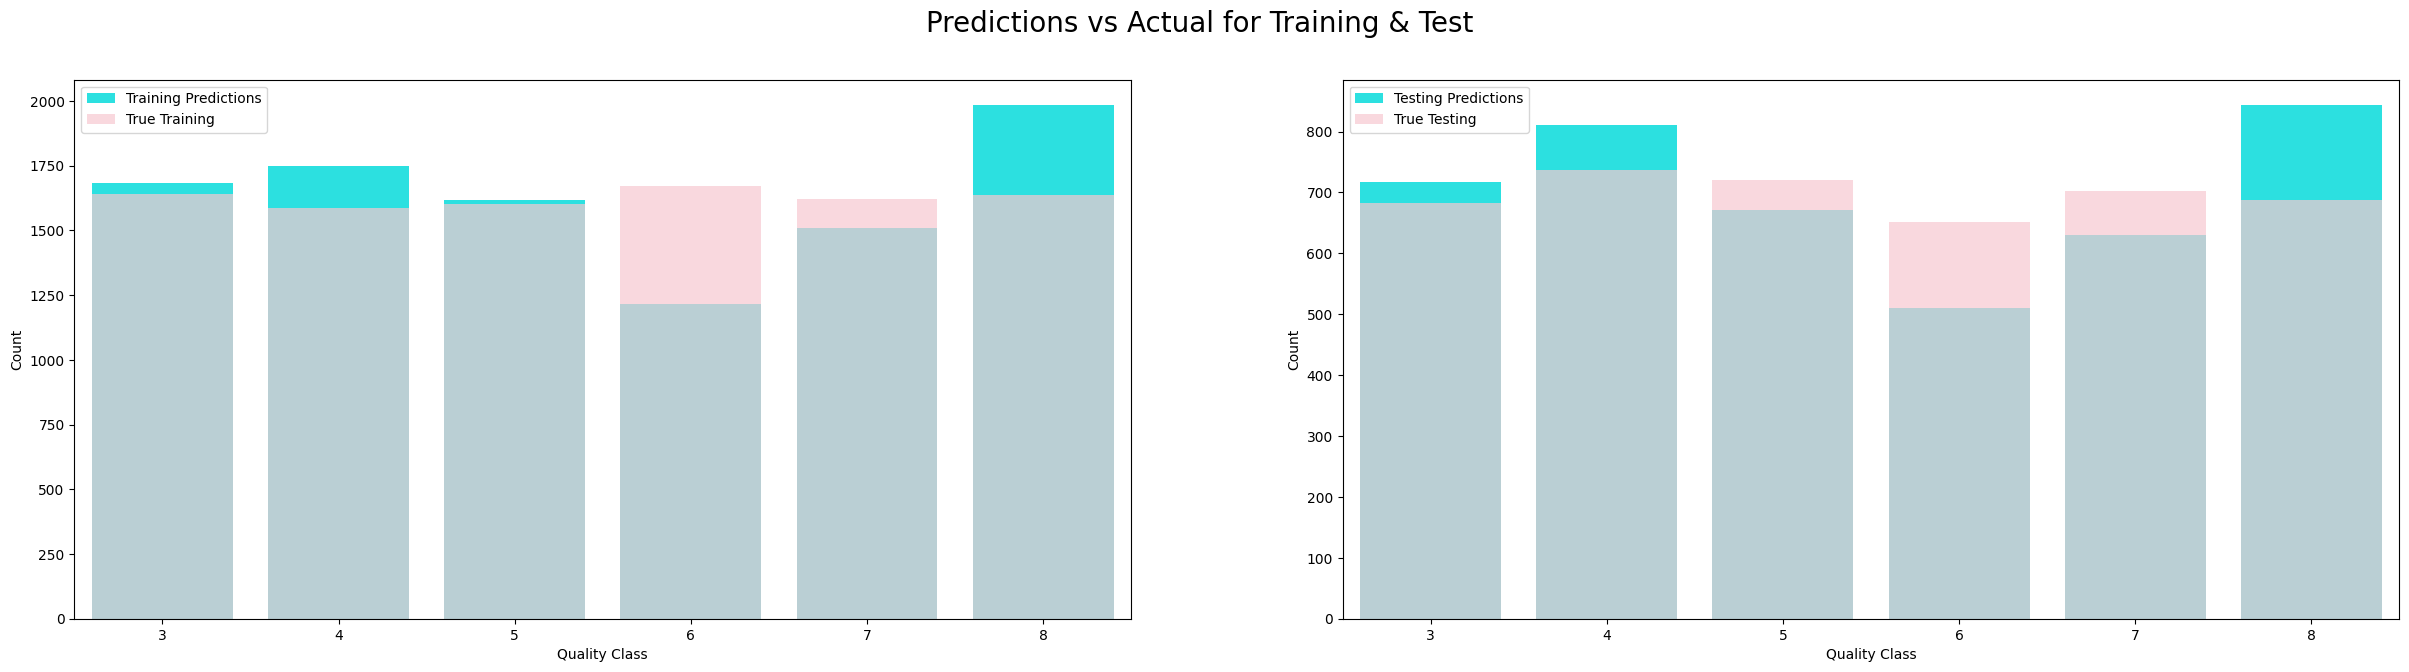

In [ ]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)


fig, ax = plt.subplots(1,2, figsize = (30,7))
sns.countplot(x =train_pred.argmax(axis =1)+3, label = f"Training Predictions", color ='cyan',alpha = 0.95, ax= ax[0])
sns.countplot(x =y_train.argmax(axis=1).astype(int) + 3, label = f"True Training",alpha=0.7, color ='pink', ax= ax[0])

sns.countplot(x =test_pred.argmax(axis =1)+3, label = f"Testing Predictions", color ='cyan',alpha = 0.95, ax= ax[1])
sns.countplot(x =y_test.argmax(axis =1)+3, label = f"True Testing", color ='pink',alpha = 0.7, ax= ax[1])
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Quality Class')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Quality Class')
ax[1].set_ylabel('Count')
plt.suptitle("Predictions vs Actual for Training & Test", fontsize = 20)
plt.show()

We see for some classes we're doing better than others in terms of predictions. We have similar prediction accuracy during training and testing.

During testing dataset, we can correctly predict classes 3,5 and 7. We don't do a great job predicting classes 4, 6, and 8. This could be due to similarity in features in these classes.

## QUESTION 2: Two models for red wine and white wine

### RED WINE MODEL

In [ ]:
red_wine_dataset_6_classes = dataset[(dataset.quality< 9) & (dataset.color_binary == 1)].reset_index()
red_wine_dataset_6_classes.dropna(inplace=True)
print(dataset.shape, red_wine_dataset_6_classes.shape)

red_wine_x_dataset = red_wine_dataset_6_classes.drop(columns=['quality'])
red_wine_y_dataset = red_wine_dataset_6_classes[['quality']] - 3

scaler = StandardScaler()
names = numerical_features
red_wine_d = scaler.fit_transform(red_wine_x_dataset[names])
red_wine_scaled_features = pd.DataFrame(red_wine_d, columns=names)

display(red_wine_scaled_features.shape, red_wine_y_dataset.shape)

from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=6)

red_wine_final_features, red_wine_final_labels =  oversample.fit_resample(red_wine_scaled_features, red_wine_y_dataset)
red_wine_final_labels_cat = to_categorical(red_wine_final_labels, num_classes=6)

print(red_wine_final_features.shape, red_wine_final_labels.shape)

from sklearn.model_selection import train_test_split

red_wine_X_train, red_wine_X_test, red_wine_y_train, red_wine_y_test=train_test_split(red_wine_final_features, red_wine_final_labels_cat, test_size=0.3,random_state=42)
print("RED WINE TRAINING DATA SHAPE : ", red_wine_X_train.shape, red_wine_y_train.shape)
print("RED WINE TEST DATA SHAPE : ", red_wine_X_test.shape, red_wine_y_test.shape)

(5320, 14) (1359, 15)


(1359, 11)

(1359, 1)

(3462, 11) (3462, 1)
RED WINE TRAINING DATA SHAPE :  (2423, 11) (2423, 6)
RED WINE TEST DATA SHAPE :  (1039, 11) (1039, 6)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                768       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 6)                 198       
                                                                 
Total params: 3046 (11.90 KB)
Trainable params: 3046 (11.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/200
27/27 - 1s - loss: 1.7375 - accuracy: 0.2465 - val_loss: 1.5637 - val_accuracy: 0.4168 - 1s/epoch - 55ms/step
Epoch 2/200
27/27 - 0s -

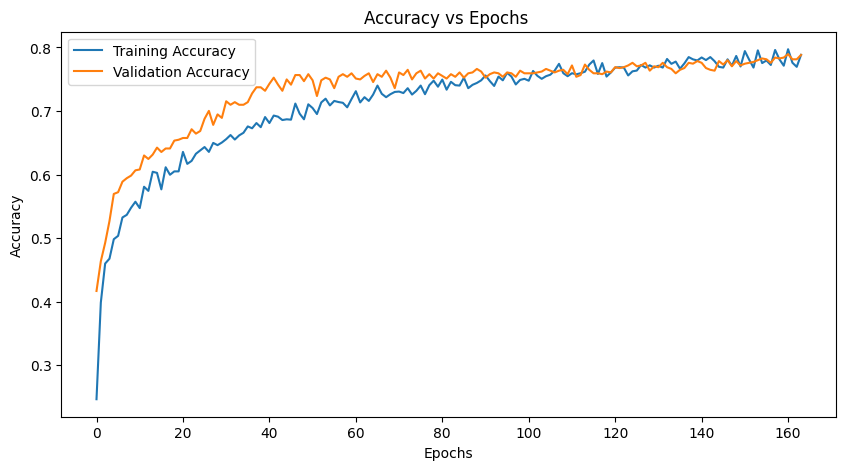

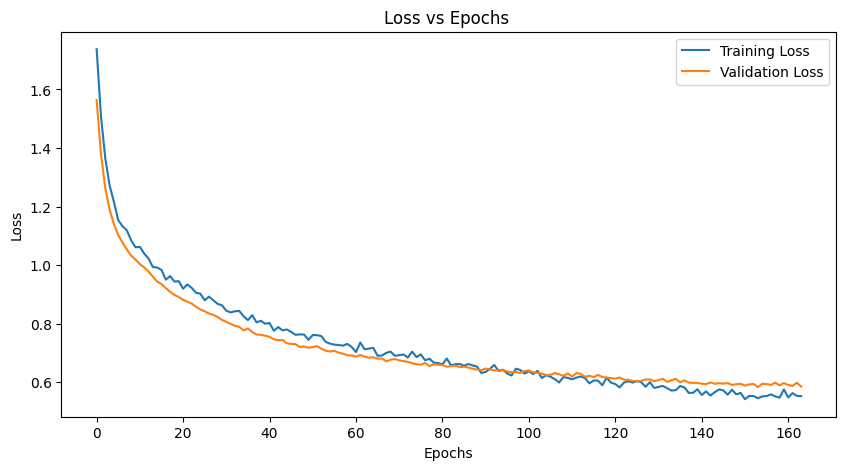

The layers of the model:
core.dense.Dense object at 0x7d8487308e80>
regularization.dropout.Dropout object at 0x7d848730a4a0>
core.dense.Dense object at 0x7d848730b4f0>
core.dense.Dense object at 0x7d848730b940>
----------------------------------------------------

33/33 - 0s - loss: 0.6310 - accuracy: 0.7575 - 58ms/epoch - 2ms/step
Test data loss : 0.6310009956359863
Test accuracy : 75.75 %


In [ ]:
red_wine_model = Sequential([
    InputLayer(input_shape=(11,)),
    Dense(units = 64, activation = "relu"),
    Dropout(0.4),
    Dense(units = 32, activation="relu"),
    Dense(units=6, activation="softmax")
])

red_wine_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(red_wine_model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

red_wine_history = red_wine_model.fit(red_wine_X_train, red_wine_y_train, epochs=200, batch_size=64, verbose=2,
                    validation_split = 0.3,
                    callbacks=[early_stopping])

plot_history(red_wine_history)

results = red_wine_model.evaluate(red_wine_X_test, red_wine_y_test, verbose=2)
print("Test data loss :", results[0])
print("Test accuracy :", np.round(results[1] * 100, 2), "%")

<small> The model trained only on red wines gives a validation accuracy of ~78%. The training curve also denotes that the model has no issues with fitting the data.

### WHITE WINE MODEL

In [ ]:
white_wine_dataset_6_classes = dataset[(dataset.quality < 9) & (dataset.color_binary == 0)].reset_index()
white_wine_dataset_6_classes.dropna(inplace=True)
print(dataset.shape, white_wine_dataset_6_classes.shape)

white_wine_x_dataset = white_wine_dataset_6_classes.drop(columns=['quality'])
white_wine_y_dataset = white_wine_dataset_6_classes[['quality']] - 3

scaler = StandardScaler()
names = numerical_features
white_wine_d = scaler.fit_transform(white_wine_x_dataset[names])
white_wine_scaled_features = pd.DataFrame(white_wine_d, columns=names)

display(white_wine_scaled_features.shape, white_wine_y_dataset.shape)

from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=6)

white_wine_final_features, white_wine_final_labels = oversample.fit_resample(white_wine_scaled_features, white_wine_y_dataset)
white_wine_final_labels_cat = to_categorical(white_wine_final_labels, num_classes=6)

print(white_wine_final_features.shape, white_wine_final_labels.shape)

from sklearn.model_selection import train_test_split

white_wine_X_train, white_wine_X_test, white_wine_y_train, white_wine_y_test = train_test_split(white_wine_final_features, white_wine_final_labels_cat, test_size=0.3, random_state=42)
print("WHITE WINE TRAINING DATA SHAPE: ", white_wine_X_train.shape, white_wine_y_train.shape)
print("WHITE WINE TEST DATA SHAPE: ", white_wine_X_test.shape, white_wine_y_test.shape)


(5320, 14) (3956, 15)


(3956, 11)

(3956, 1)

(10728, 11) (10728, 1)
WHITE WINE TRAINING DATA SHAPE:  (7509, 11) (7509, 6)
WHITE WINE TEST DATA SHAPE:  (3219, 11) (3219, 6)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                768       
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 6)                 198       
                                                                 
Total params: 3046 (11.90 KB)
Trainable params: 3046 (11.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/400
83/83 - 1s - loss: 1.6757 - accuracy: 0.2979 - val_loss: 1.4424 - val_accuracy: 0.4274 - 1s/epoch - 14ms/step
Epoch 2/400
83/83 - 0s -

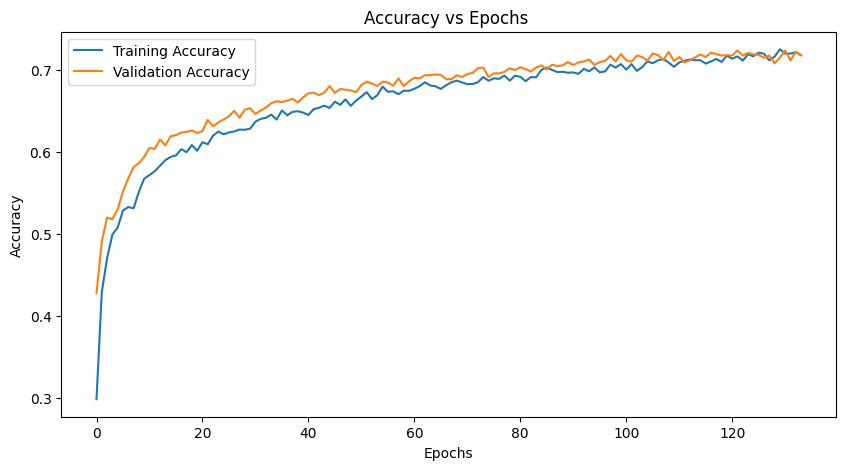

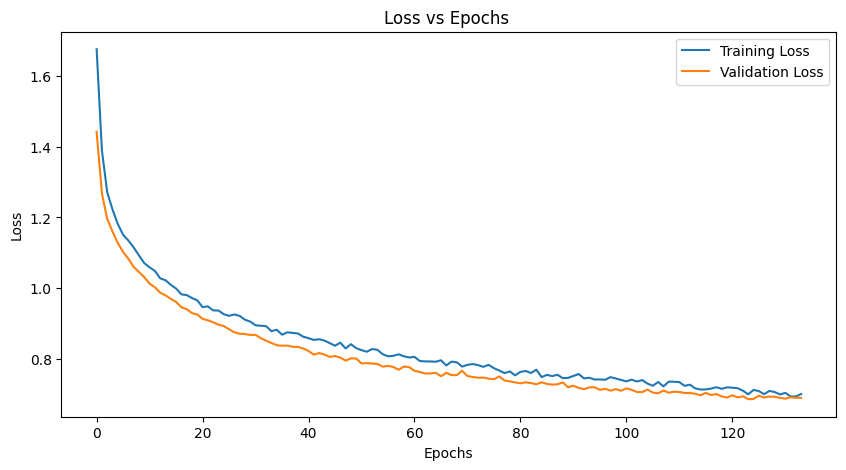

The layers of the model:
core.dense.Dense object at 0x7d8487308e80>
regularization.dropout.Dropout object at 0x7d848730a4a0>
core.dense.Dense object at 0x7d848730b4f0>
core.dense.Dense object at 0x7d848730b940>
----------------------------------------------------

101/101 - 0s - loss: 0.7140 - accuracy: 0.6999 - 131ms/epoch - 1ms/step
Test data loss: 0.7140144109725952
Test accuracy: 69.99 %


In [ ]:
white_wine_model = Sequential([
    InputLayer(input_shape=(11,)),
    Dense(units=64, activation="relu"),
    Dropout(0.2),
    Dense(units=32, activation="relu"),
    Dense(units=6, activation="softmax")
])

white_wine_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(white_wine_model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

white_wine_history = white_wine_model.fit(white_wine_X_train, white_wine_y_train, epochs=400, batch_size=64, verbose=2,
                    validation_split=0.3,
                    callbacks=[early_stopping])

plot_history(white_wine_history)

results = white_wine_model.evaluate(white_wine_X_test, white_wine_y_test, verbose=2)
print("Test data loss:", results[0])
print("Test accuracy:", np.round(results[1] * 100, 2), "%")


<small> The model trained on only white wines gives a validation accuracy ~ 72%. On observing the training curves, we can see that training accuracy continues to increase indicating signs of overfitting. It's probably not the good to use the this model to predict the quality of white wines.

### EVALUATING IF IT IS BETTER TO USE COMBINED MODEL / SEPARATE MODEL FOR RED WINE

33/33 [==============================] - 0s 2ms/step


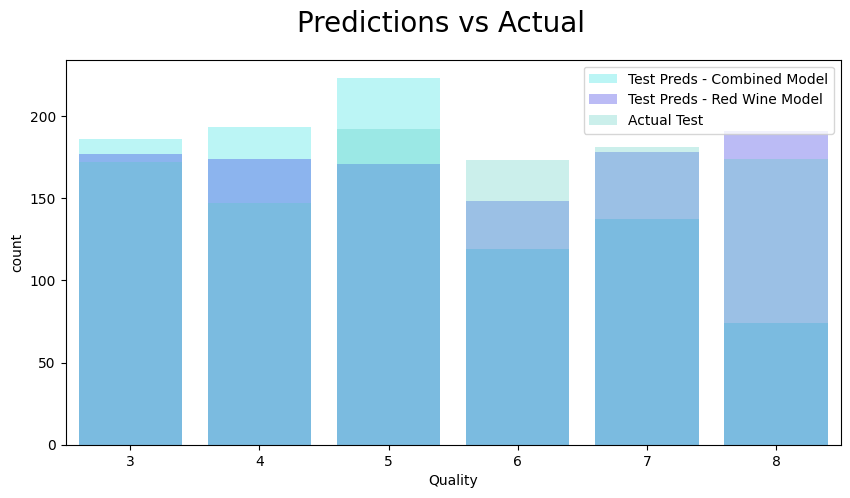

30/30 - 0s - loss: 0.6835 - accuracy: 0.7393 - 179ms/epoch - 6ms/step
Combined Model Test data loss: 0.68
Combined Model Test accuracy: 73.93 %
33/33 - 0s - loss: 0.6310 - accuracy: 0.7575 - 65ms/epoch - 2ms/step
Red Wine Model Test data loss: 1.0
Red Wine Model  Test accuracy: 75.75 %


In [ ]:
red_wine_test_pred_1 = model.predict(X_test[X_test['color_binary']==1])
red_wine_test_pred_2 = red_wine_model.predict(red_wine_X_test)

fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.countplot(x =red_wine_test_pred_1.argmax(axis =1)+3, label = f"Test Preds - Combined Model", color ='cyan', alpha=0.3, ax= ax)
sns.countplot(x =red_wine_test_pred_2.argmax(axis =1)+3, label = f"Test Preds - Red Wine Model", color ='blue', alpha=0.3, ax= ax)
sns.countplot(x =red_wine_y_test.argmax(axis=1) + 3, label = f"Actual Test",color ='turquoise',  alpha=0.3, ax= ax)
ax.set_xlabel("Quality")
ax.legend()
plt.suptitle("Predictions vs Actual", fontsize = 20)
plt.show()

results_1 = model.evaluate(test_dataset[test_dataset['color_binary']==1].drop(columns=['quality_upd' + str(i) for i in range(6)]),
                           test_dataset[test_dataset['color_binary']==1][['quality_upd' + str(i) for i in range(6)]],
                           verbose=2)
print("Combined Model Test data loss:", np.round(results_1[0],2))
print("Combined Model Test accuracy:", np.round(results_1[1] * 100, 2), "%")

results_2 = red_wine_model.evaluate(red_wine_X_test, red_wine_y_test, verbose=2)
print("Red Wine Model Test data loss:", np.round(results_2[0]))
print("Red Wine Model  Test accuracy:", np.round(results_2[1] * 100, 2), "%")

#### **Insights:**
<small> From the results above, we see that for red wine, it's better to use a separate model than a combined model. The accuracy improves by ~2% if we use a separate model.

### EVALUATING IF IT IS BETTER TO USE COMBINED MODEL / SEPARATE MODEL FOR WHITE WINE

101/101 [==============================] - 0s 1ms/step


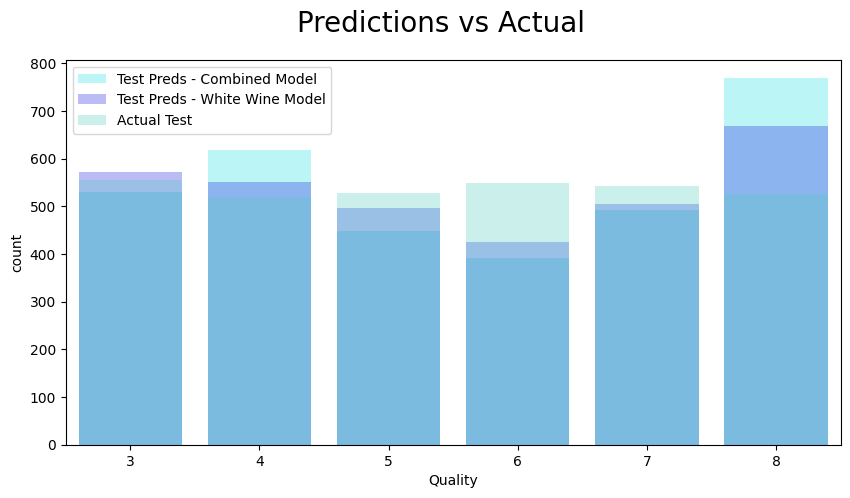

102/102 - 0s - loss: 0.7135 - accuracy: 0.7308 - 149ms/epoch - 1ms/step
Combined Model Test data loss: 0.71
Combined Model Test accuracy: 73.08 %
101/101 - 0s - loss: 0.7140 - accuracy: 0.6999 - 143ms/epoch - 1ms/step
White Wine Model Test data loss: 1.0
White Wine Model  Test accuracy: 69.99 %


In [ ]:
white_wine_test_pred_1 = model.predict(X_test[X_test['color_binary']==0])
white_wine_test_pred_2 = white_wine_model.predict(white_wine_X_test)

fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.countplot(x =white_wine_test_pred_1.argmax(axis =1)+3, label = f"Test Preds - Combined Model", color ='cyan', alpha=0.3, ax= ax)
sns.countplot(x =white_wine_test_pred_2.argmax(axis =1)+3, label = f"Test Preds - White Wine Model", color ='blue', alpha=0.3, ax= ax)
sns.countplot(x =white_wine_y_test.argmax(axis=1) + 3, label = f"Actual Test",color ='turquoise',  alpha=0.3, ax= ax)
ax.set_xlabel("Quality")
ax.legend()
plt.suptitle("Predictions vs Actual", fontsize = 20)
plt.show()

results_1 = model.evaluate(test_dataset[test_dataset['color_binary']==0].drop(columns=['quality_upd' + str(i) for i in range(6)]),
                           test_dataset[test_dataset['color_binary']==0][['quality_upd' + str(i) for i in range(6)]],
                           verbose=2)
print("Combined Model Test data loss:", np.round(results_1[0],2))
print("Combined Model Test accuracy:", np.round(results_1[1] * 100, 2), "%")

results_2 = white_wine_model.evaluate(white_wine_X_test, white_wine_y_test, verbose=2)
print("White Wine Model Test data loss:", np.round(results_2[0]))
print("White Wine Model  Test accuracy:", np.round(results_2[1] * 100, 2), "%")

<small> We see the combined model has better accuracy for white wines indicating the combined model to be better at predicting quality of white wines.

## Question 3: Train a model on white wine (respectively red wine) and fine-tune it on red wine (resp. white wine).

In [ ]:
white_wine_model_copy = white_wine_model

Epoch 1/400
27/27 - 0s - loss: 0.4844 - accuracy: 0.8184 - val_loss: 0.6022 - val_accuracy: 0.7923 - 184ms/epoch - 7ms/step
Epoch 2/400
27/27 - 0s - loss: 0.4717 - accuracy: 0.8172 - val_loss: 0.5920 - val_accuracy: 0.7827 - 171ms/epoch - 6ms/step
Epoch 3/400
27/27 - 0s - loss: 0.4770 - accuracy: 0.8208 - val_loss: 0.5888 - val_accuracy: 0.7882 - 190ms/epoch - 7ms/step
Epoch 4/400
27/27 - 0s - loss: 0.4693 - accuracy: 0.8272 - val_loss: 0.6082 - val_accuracy: 0.7882 - 182ms/epoch - 7ms/step
Epoch 5/400
27/27 - 0s - loss: 0.4697 - accuracy: 0.8219 - val_loss: 0.5893 - val_accuracy: 0.7868 - 300ms/epoch - 11ms/step
Epoch 6/400
27/27 - 0s - loss: 0.4804 - accuracy: 0.8149 - val_loss: 0.5866 - val_accuracy: 0.7813 - 262ms/epoch - 10ms/step
Epoch 7/400
27/27 - 0s - loss: 0.4649 - accuracy: 0.8213 - val_loss: 0.5918 - val_accuracy: 0.7868 - 204ms/epoch - 8ms/step
Epoch 8/400
27/27 - 0s - loss: 0.4687 - accuracy: 0.8131 - val_loss: 0.6032 - val_accuracy: 0.7950 - 190ms/epoch - 7ms/step
Epoch 

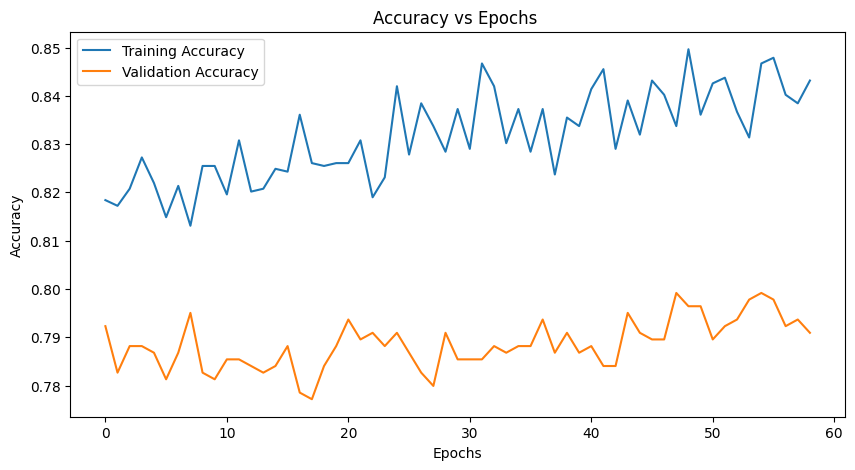

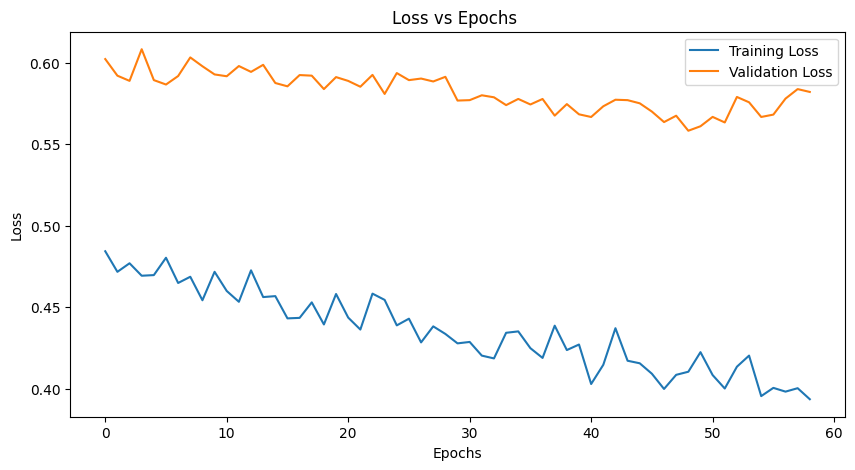

The layers of the model:
core.dense.Dense object at 0x7d8487308e80>
regularization.dropout.Dropout object at 0x7d848730a4a0>
core.dense.Dense object at 0x7d848730b4f0>
core.dense.Dense object at 0x7d848730b940>
----------------------------------------------------

33/33 - 0s - loss: 0.6294 - accuracy: 0.7594 - 69ms/epoch - 2ms/step
FINE TUNED WHITE WINE MODEL Test data (RED WINE) loss: 0.6293802261352539
FINE TUNED WHITE WINE MODEL Test (RED WINE) accuracy: 75.94 %
33/33 - 0s - loss: 7.8936 - accuracy: 0.2791 - 71ms/epoch - 2ms/step
ONLY RED WINE MODEL Test data (RED WINE) loss: 7.893633842468262
ONLY RED WINE MODEL Test (RED WINE) accuracy: 27.91 %


In [ ]:
red_data_on_white_wine_history = white_wine_model_copy.fit(red_wine_X_train, red_wine_y_train, epochs=400, batch_size=64, verbose=2,
                                                                  validation_split=0.3, callbacks=[early_stopping])

plot_history(red_data_on_white_wine_history)

results = white_wine_model_copy.evaluate(red_wine_X_test, red_wine_y_test, verbose=2)
print("FINE TUNED WHITE WINE MODEL Test data (RED WINE) loss:", results[0])
print("FINE TUNED WHITE WINE MODEL Test (RED WINE) accuracy:", np.round(results[1] * 100, 2), "%")

results_2 = red_wine_model.evaluate(red_wine_X_test, red_wine_y_test, verbose=2)
print("ONLY RED WINE MODEL Test data (RED WINE) loss:", results_2[0])
print("ONLY RED WINE MODEL Test (RED WINE) accuracy:", np.round(results_2[1] * 100, 2), "%")

<small> The model originally trained only on red wine data gives a slighly better accuracy than the model trained on white wine data and fine-tuned on red wine data. But this model does show slight signs of overfitting as the learning curve does not flatten even after 100+ epochs. There is a similar trend for training loss as it is not flattening.

In [ ]:
red_wine_model_copy = red_wine_model

Epoch 1/400
83/83 - 0s - loss: 0.7653 - accuracy: 0.6849 - val_loss: 0.7089 - val_accuracy: 0.7079 - 324ms/epoch - 4ms/step
Epoch 2/400
83/83 - 0s - loss: 0.7643 - accuracy: 0.6891 - val_loss: 0.7098 - val_accuracy: 0.7084 - 247ms/epoch - 3ms/step
Epoch 3/400
83/83 - 0s - loss: 0.7603 - accuracy: 0.6802 - val_loss: 0.7076 - val_accuracy: 0.7102 - 242ms/epoch - 3ms/step
Epoch 4/400
83/83 - 0s - loss: 0.7655 - accuracy: 0.6846 - val_loss: 0.7091 - val_accuracy: 0.7084 - 223ms/epoch - 3ms/step
Epoch 5/400
83/83 - 0s - loss: 0.7534 - accuracy: 0.6844 - val_loss: 0.7106 - val_accuracy: 0.7057 - 256ms/epoch - 3ms/step
Epoch 6/400
83/83 - 0s - loss: 0.7594 - accuracy: 0.6903 - val_loss: 0.7107 - val_accuracy: 0.7124 - 234ms/epoch - 3ms/step
Epoch 7/400
83/83 - 0s - loss: 0.7539 - accuracy: 0.6897 - val_loss: 0.7081 - val_accuracy: 0.7071 - 228ms/epoch - 3ms/step
Epoch 8/400
83/83 - 0s - loss: 0.7548 - accuracy: 0.6954 - val_loss: 0.7039 - val_accuracy: 0.7115 - 217ms/epoch - 3ms/step
Epoch 9/

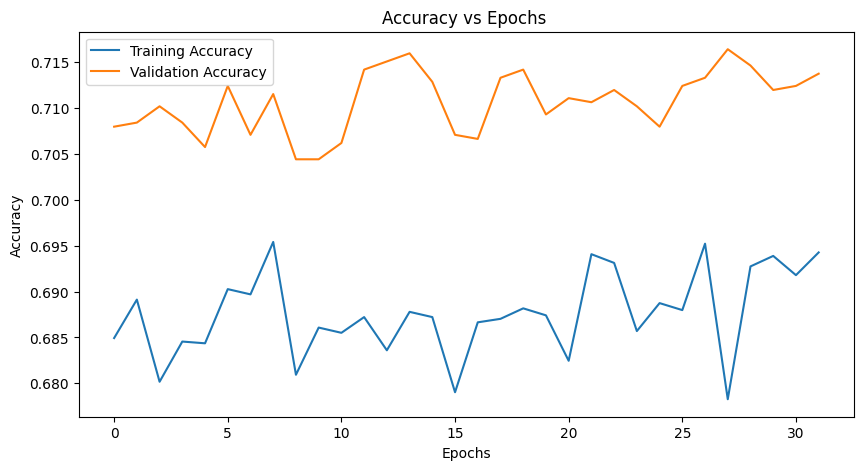

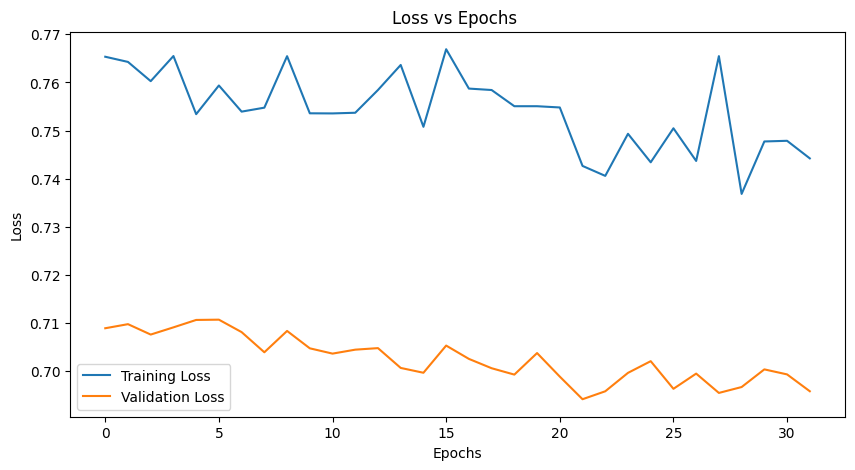

The layers of the model:
core.dense.Dense object at 0x7d8487308e80>
regularization.dropout.Dropout object at 0x7d848730a4a0>
core.dense.Dense object at 0x7d848730b4f0>
core.dense.Dense object at 0x7d848730b940>
----------------------------------------------------

101/101 - 0s - loss: 0.6984 - accuracy: 0.7117 - 144ms/epoch - 1ms/step
FINE TUNED RED WINE MODEL Test data (WHITE WINE) loss: 0.6983727216720581
FINE TUNED RED WINE MODEL Test (WHITE WINE) accuracy: 71.17 %
101/101 - 0s - loss: 6.3583 - accuracy: 0.2970 - 143ms/epoch - 1ms/step
ONLY WHITE WINE MODEL Test data (WHITE WINE) loss: 6.358301639556885
ONLY WHITE WINE MODEL Test (WHITE WINE) accuracy: 29.7 %


In [ ]:
white_data_on_red_wine_history = red_wine_model_copy.fit(white_wine_X_train, white_wine_y_train, epochs=400, batch_size=64, verbose=2,
                                                                  validation_split=0.3, callbacks=[early_stopping])

plot_history(white_data_on_red_wine_history)

results = red_wine_model_copy.evaluate(white_wine_X_test, white_wine_y_test, verbose=2)
print("FINE TUNED RED WINE MODEL Test data (WHITE WINE) loss:", results[0])
print("FINE TUNED RED WINE MODEL Test (WHITE WINE) accuracy:", np.round(results[1] * 100, 2), "%")

results_2 = white_wine_model.evaluate(white_wine_X_test, white_wine_y_test, verbose=2)
print("ONLY WHITE WINE MODEL Test data (WHITE WINE) loss:", results_2[0])
print("ONLY WHITE WINE MODEL Test (WHITE WINE) accuracy:", np.round(results_2[1] * 100, 2), "%")

**Insights**:  
<small>The model originally trained on red wine data and fine-tuned on white wine data gives a way better accuracy than the model trained only on white wine data.

<big>**Overall Insights:**</big>  

We tried several different models and classification problems. We started with simpler models and advanced to more dense neural networks. We introduced regularizations and callbacks to prevent overfitting and help the model generalize better on training data. During exploration, we noticed that the target variable does not clearly get distinguished between features.This learning got reinfornced when we started training models and did not get high validation accuracy scores.  
We also had imbalanced data. For this purpose, we introduced the SMOTE sampling technique to deal with imbalanced data. We started training on the SMOTE sampling data and got slighly higher accuracy, but not as high as expected, again due to not enough differencing between features against target.  


We  tested whether it was better to use combined or separate models for red wine and white wine, and we found that separate models were better, especially for red wine.

In the end, we tested whether it was better to fine tune the model for one type of wine and train it on the other type. We found that fine-tuned models appear to generalize better to the test data of the wine type they were not initially trained on, compared to the specialized models trained on a single type of wine.  
The model originally trained on white wine data and fine-tuned on red wine data gave the highest accuracy score.

<big>**Future Considerations**</big>  
We recommend increasing the sample size to have balanced dataset, as well as introduce new features if possible that make the difference between different wine scores.





